<a href="https://colab.research.google.com/github/shanikairoshi/QFL_Experiments/blob/main/Finalized_No_Teleported_medium_Noise_DQFL_Genome_non_IID.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Setting	p1	p2	Result Observation

Low noise -(ideal)
p1 0.001
p2 0.005
Benchmark "almost ideal" behavior

Medium noise
p1 0.005
p2 0.015
Observe degradation, fairness

High noise
p1 0.01
p2 0.02
Worst-case robustness

In [1]:
!pip install qiskit qiskit-machine-learning scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 78.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 82.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.3/37.3 MB 64.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 MB 46.7 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.16.2
    Uninstalling scipy-1.16.2:
      Successfully uninstalled scipy-1.16.2


We are going to implement telepotation to establish a communication between clients.

Here are the integration steps:

##Model Update Encoding:
After a federated round, choose the best client’s model. Extract its parameter vector—representing the critical update—and encode each parameter as a quantum state. In our simplified version, we use an RX rotation on a qubit where the rotation angle is determined by the parameter value.

##Quantum Teleportation:
For each parameter (or for a group of parameters, if you build a multi‑qubit circuit), use a teleportation circuit. In our demonstration, we build a function that creates a teleportation circuit to “transfer” the encoded value. In practice, the protocol would need to generate an entangled pair between sender and receiver, perform a Bell measurement, and then use classical communication to apply the correction on the receiver’s side.

##Update Transfer:
Replace or update the global model’s parameters with the teleported values. Then distribute these updated parameters to all the participating clients.



In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Tue Sep 23 10:39:36 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   53C    P8             11W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:

%%capture
!pip install genomic-benchmarks
!pip install qiskit qiskit_machine_learning qiskit_algorithms
!pip install qiskit-aer
!pip install qiskit
!pip install qiskit_machine_learning

In [4]:

import os
from datetime import datetime
import time
import csv
from tqdm import tqdm


# ─── 0. Capture the start timestamp ────────────────────────────────────────────
start_ts   = datetime.now()
# Format as “DD_MM_YYYY_HHMMSS” (no colons, so filesystem‑safe)
start_str  = start_ts.strftime("%d_%m_%Y_%H%M%S")

# ─── 1. Experiment configuration ───────────────────────────────────────────────
num_epochs = 10 #50
max_train_iterations = 100
samples_per_epoch=50 #10
word_size = 40
use_teleportation= False   # or False/True
use_noise =True
'''
num_epochs = 2 #50
max_train_iterations = 100
samples_per_epoch=10 #10
word_size = 40
use_teleportation             = False   # or False/True
use_noise =True
'''

num_clients = 5#8 test with teleport
num_federated_layers = 10
num_deep_unfolding_iterations =5
initial_learning_rate = 0.15
meta_learning_rate=1e-4
initial_perturbation = 0.15
momentum = 0.95
gradient_moving_avg = 0

# Define federated learning with accuracy tracking
num_features = 5
global_model_weights, global_model_accuracy = {}, []
clients_train_accuracies, clients_test_accuracies = [], []
round_times = []
overall_start = time.time()


# ─── 2. Helper to make floats filesystem‑safe (“0.15” → “0p15”) ─────────────────
def fmt(x: float) -> str:
    return str(x).replace('.', 'p')

# ─── 3. Build the hyperparameter string ───────────────────────────────────────
param_str = (
    f"clients{num_clients}"
    f"_layers{num_federated_layers}"
    f"_du{num_deep_unfolding_iterations}"
    f"_lr{fmt(initial_learning_rate)}"
    f"_pert{fmt(initial_perturbation)}"
)

# ─── 4. Date stamp and Teleport flag ───────────────────────────────────────────
date_str    = datetime.now().strftime("%d_%m_%Y")               # e.g. "22_04_2025"
teleport_pl = "Teleport" if use_teleportation else "NoTeleport"
noise = "WithNoise" if use_noise else "NoNoise"

# ─── 5. Assemble filenames for each artifact ─────────────────────────────────
drive_root = "/content/drive/MyDrive/Teleportation"


#  a) Best‑client CSV
best_client_csv_file = os.path.join(
    drive_root,
    f"Noise_No_Tele_DQFL_MediumNoise_Genome_non_IID_Best_Client_{date_str}_{teleport_pl}_{noise}_{param_str}.csv"
)

#  b) Global‑accuracy CSV
global_csv_file = os.path.join(
    drive_root,
    f"Noise_No_Tele_DQFL_MediumNoise_Genome_non_IID_Global_{date_str}_{teleport_pl}_{noise}_{param_str}.csv"
)

#  c) Local CSV
csv_file = os.path.join(
    drive_root,
    f"Noise_No_Tele_DQFL_MediumNoise_Genome_non_IID_Local_{date_str}_{teleport_pl}_{noise}_{param_str}.csv"
)

validation_csv_file = os.path.join(
    drive_root,
    f"Noise_No_Tele_DQFL_MediumNoise_Genome_non_IID_validation_Loss_{date_str}_{teleport_pl}_{noise}_{param_str}.csv"
)


In [5]:

from genomic_benchmarks.dataset_getters.pytorch_datasets import DemoHumanOrWorm
import time
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes
#from qiskit_machine_learning.algorithms.classifiers import VQC
from qiskit.primitives import BackendSampler
from functools import partial
from qiskit_aer import Aer

from qiskit_machine_learning.neural_networks import SamplerQNN
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes

from qiskit_algorithms.optimizers import SPSA
import numpy as np
import time
#from IPython.display import clear_output
import matplotlib.pyplot as plt
from qiskit_algorithms.utils import algorithm_globals # Import algorithm_globals

# Set random seed for reproducibility using algorithm_globals
algorithm_globals.random_seed = 42  # Set seed globally


test_set = DemoHumanOrWorm(split='test', version=0)
train_set = DemoHumanOrWorm(split='train', version=0)

data_set = train_set
# data_set = train_set + test_set
len(data_set)


from collections import defaultdict
import numpy as np


word_combinations = defaultdict(int)
iteration = 1
for text, _ in data_set:
    for i in range(len(text)):
        word = text[i:i+word_size]
        if word_combinations.get(word) is None:
          word_combinations[word] = iteration
          iteration += 1



print("First sample int the data_set variable: ")
print(data_set[0])

print("\nFirst 5 samples in the word_combinations dict.")
for key, value in list(word_combinations.items())[:5]:
    print(key, value)


import numpy as np
# Preprocess the training set
np_data_set = []
for i in range(len(data_set)):
    sequence, label = data_set[i]
    sequence = sequence.strip()  # Remove any leading/trailing whitespace
    words = [sequence[i:i + word_size] for i in range(0, len(sequence), word_size)]  # Split the sequence into 4-letter words
    int_sequence = np.array([word_combinations[word] for word in words])
    data_point = {'sequence': int_sequence, 'label': label}
    np_data_set.append(data_point)


print("First 5 samples of encoded data:")
np_data_set[:5]


rng = np.random.default_rng(42)   # fixed seed for reproducibility
rng.shuffle(np_data_set)          # shuffle in place, but reproducible
print("First 5 samples of encoded shuffled data:")
np_data_set[:5]
from sklearn.preprocessing import MinMaxScaler

sequences = np.array([item['sequence'] for item in np_data_set])
sequences = np.vstack(sequences)

scaler = MinMaxScaler()

sequences_scaled = scaler.fit_transform(sequences)

for i, item in enumerate(np_data_set):
    item['sequence'] = sequences_scaled[i]

print("First 5 samples of scaled encoded shuffled data:")
np_data_set[:5]


np_train_data = np_data_set[:5000]
np_test_data = np_data_set[-1000:]

print(f"Length of np_train_data: {len(np_train_data)}")
print(f"Length of np_test_data: {len(np_test_data)}")

test_sequences = [data_point["sequence"] for data_point in np_test_data]
test_labels = [data_point["label"] for data_point in np_test_data]
test_sequences = np.array(test_sequences)
test_labels = np.array(test_labels)


#---------------------------------------


class Client:
   def __init__(self, data, test_data):  # Add test_data to __init__
        self.data = data
        self.test_data = test_data  # Store test_data as an attribute
        self.models = []
        self.train_scores = []
        self.test_scores = []
        self.primary_model = None

def split_dataset(num_clients, num_epochs, samples_per_epoch):
    clients = []
    # Split test data across clients
    test_samples_per_client = len(np_test_data) // num_clients

    for i in range(num_clients):
        client_data = []
        for j in range(num_epochs):
            start_idx = (i * num_epochs * samples_per_epoch) + (j * samples_per_epoch)
            end_idx = (i * num_epochs * samples_per_epoch) + ((j + 1) * samples_per_epoch)
            client_data.append(np_train_data[start_idx:end_idx])

        # Assign a subset of the test data to each client
        test_start_idx = i * test_samples_per_client
        test_end_idx = (i + 1) * test_samples_per_client
        client_test_data = np_test_data[test_start_idx:test_end_idx]

        # Create Client instance with both train and test data
        clients.append(Client(client_data, client_test_data))

    return clients

clients = split_dataset(num_clients, num_epochs, samples_per_epoch)

# Verify test data distribution across clients
for index, client in enumerate(clients):
    print(f"Client {index} Test Data Length: {len(client.test_data)}")


/usr/local/lib/python3.12/dist-packages/genomic_benchmarks/utils/datasets.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


First sample int the data_set variable: 
('CACTTCTCTCTGGCTCTGGCCTCCTGGGGCTCCCTGCAGCTGAGGCCAAGGCTGGGGTGTGGCCGCCTCCGCGGCAGGCCGGCGGGCTGGGCTCGGGTGGGCCGGGGCGCTCCCTCCTTTCCACGCCCCCACCTCGGGTTCCCCCGTTCATCGCCCCCCCATCCCCATCTCAGCGGGTCCCGGCTTCCTTACATGGTCAC', 0)

First 5 samples in the word_combinations dict.
CACTTCTCTCTGGCTCTGGCCTCCTGGGGCTCCCTGCAGC 1
ACTTCTCTCTGGCTCTGGCCTCCTGGGGCTCCCTGCAGCT 2
CTTCTCTCTGGCTCTGGCCTCCTGGGGCTCCCTGCAGCTG 3
TTCTCTCTGGCTCTGGCCTCCTGGGGCTCCCTGCAGCTGA 4
TCTCTCTGGCTCTGGCCTCCTGGGGCTCCCTGCAGCTGAG 5
First 5 samples of encoded data:
First 5 samples of encoded shuffled data:
First 5 samples of scaled encoded shuffled data:
Length of np_train_data: 5000
Length of np_test_data: 1000
Client 0 Test Data Length: 200
Client 1 Test Data Length: 200
Client 2 Test Data Length: 200
Client 3 Test Data Length: 200
Client 4 Test Data Length: 200


In [ ]:
import qiskit.primitives
print(dir(qiskit.primitives))

['BackendEstimator', 'BackendEstimatorV2', 'BackendSampler', 'BackendSamplerV2', 'BaseEstimator', 'BaseEstimatorV1', 'BaseEstimatorV2', 'BasePrimitiveJob', 'BaseSampler', 'BaseSamplerV1', 'BaseSamplerV2', 'BindingsArrayLike', 'BitArray', 'DataBin', 'Estimator', 'EstimatorPubLike', 'EstimatorResult', 'ObservableLike', 'ObservablesArrayLike', 'PrimitiveJob', 'PrimitiveResult', 'PubResult', 'Sampler', 'SamplerPubLike', 'SamplerPubResult', 'SamplerResult', 'StatevectorEstimator', 'StatevectorSampler', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', 'backend_estimator', 'backend_estimator_v2', 'backend_sampler', 'backend_sampler_v2', 'base', 'containers', 'estimator', 'primitive_job', 'sampler', 'statevector_estimator', 'statevector_sampler', 'utils']


Split data into validation and train set

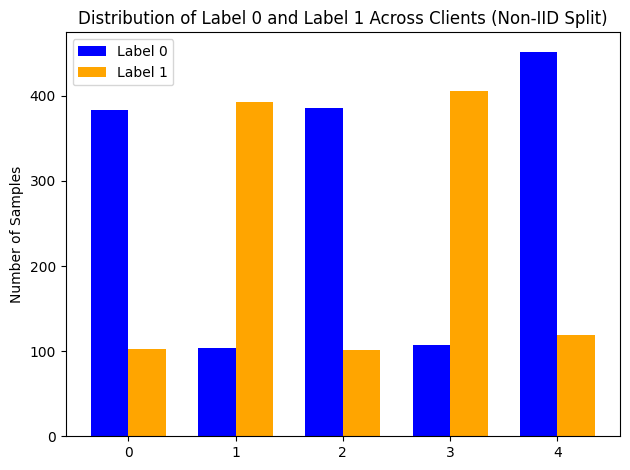

In [6]:
import random
import matplotlib.pyplot as plt
import numpy as np

class Client:
    def __init__(self, data, test_data):  # Add test_data to __init__
        self.data = data
        self.test_data = test_data  # Store test_data as an attribute
        self.models = []
        self.train_scores = []
        self.test_scores = []
        self.primary_model = None

def split_dataset_quantity_non_iid_binary(dataset, num_clients, num_epochs, samples_per_epoch, non_iid_ratio=0.5, quantity_variation=0.2):
    """
    Splits a binary-labeled dataset into non-IID partitions among clients, varying the quantity of data.

    Args:
        dataset: list of dicts with 'features' and 'label'.
        num_clients: total number of clients.
        num_epochs: number of epochs.
        samples_per_epoch: base samples assigned to each client per epoch.
        non_iid_ratio: how skewed (0.5 = balanced, 1.0 = completely biased to one label).
        quantity_variation: how much to vary the quantity of data per client (0.0 = no variation, 1.0 = up to double the base samples).
    """
    label_0 = [sample for sample in dataset if sample["label"] == 0]
    label_1 = [sample for sample in dataset if sample["label"] == 1]
    random.shuffle(label_0)
    random.shuffle(label_1)

    client_label_0_counts = []
    client_label_1_counts = []

    # Create Client objects and assign data to them
    clients_data = []

    for client_id in range(num_clients):
        client_data = []
        selected_label_0 = []
        selected_label_1 = []
        # Track the number of labels assigned to each client
        client_label_0_count = 0
        client_label_1_count = 0

        for epoch in range(num_epochs):
            # Vary the quantity of data per client
            epoch_samples = int(samples_per_epoch * (1 + random.uniform(-quantity_variation, quantity_variation)))

            if client_id % 2 == 0:  # Even client gets a higher proportion of label 0
                num_label_0 = int(epoch_samples * non_iid_ratio)
                num_label_1 = epoch_samples - num_label_0
            else:  # Odd client gets a higher proportion of label 1
                num_label_1 = int(epoch_samples * non_iid_ratio)
                num_label_0 = epoch_samples - num_label_1

            # Select the required number of samples for each label
            selected_label_0 = label_0[:num_label_0]
            selected_label_1 = label_1[:num_label_1]

            # Update the remaining dataset
            label_0 = label_0[num_label_0:]
            label_1 = label_1[num_label_1:]

            # Update counts for label distribution
            client_label_0_count += num_label_0
            client_label_1_count += num_label_1

            # Append data for the current epoch to the client's data
            client_data.append(selected_label_0 + selected_label_1);

        # Store the final counts for the client
        client_label_0_counts.append(client_label_0_count)
        client_label_1_counts.append(client_label_1_count)

        clients_data.append(client_data)  # Append client's data for all epochs



    # Plotting the results
    clients = list(range(num_clients))
    width = 0.35  # the width of the bars
    x = np.arange(len(clients))  # the label locations

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, client_label_0_counts, width, label='Label 0', color='blue')
    rects2 = ax.bar(x + width/2, client_label_1_counts, width, label='Label 1', color='orange')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Number of Samples')
    ax.set_title(f'Distribution of Label 0 and Label 1 Across Clients (Non-IID Split)')
    ax.set_xticks(x)
    ax.set_xticklabels(clients)
    ax.legend()

    fig.tight_layout()

    plt.show()
    return clients_data # Return the clients data

# Example usage
#dataset = [{'features': [random.random(), random.random()], 'label': random.choice([0, 1])} for _ in range(1000)]
clients=[]# Initialize the list of Client objects
client_data_list =split_dataset_quantity_non_iid_binary(
  dataset=np_train_data,
  num_clients=5,
  num_epochs=10,
  samples_per_epoch=50,
  non_iid_ratio=0.8,  # 0.5, 0, 1.0
  quantity_variation=0.5) #


for client_data in client_data_list:
    client = Client(client_data, test_data=np_test_data)
    clients.append(client)


Data Load and preprocessing

In [ ]:
def split_dataset_for_epochs(num_clients, num_epochs, train_data, test_data, samples_per_epoch):
    """
    Split the dataset across multiple epochs and clients.

    Args:
        num_clients (int): Number of clients.
        num_epochs (int): Number of epochs.
        train_data (list): List of training data points.
        test_data (list): List of test data points.
        samples_per_epoch (int): Number of samples per epoch.

    Returns:
        list: A list of Client objects with assigned data for each epoch.
    """
    clients = []

    # Split the training data across epochs and clients
    train_samples_per_client = len(train_data) // num_clients

    for i in range(num_clients):
        client_data_for_epochs = []

        for epoch in range(num_epochs):
            start_idx = (i * num_epochs * samples_per_epoch) + (epoch * samples_per_epoch)
            end_idx = (i * num_epochs * samples_per_epoch) + ((epoch + 1) * samples_per_epoch)
            client_data_for_epochs.append(train_data[start_idx:end_idx])

        # Assign test data to each client
        test_samples_per_client = len(test_data) // num_clients
        test_start_idx = i * test_samples_per_client
        test_end_idx = (i + 1) * test_samples_per_client
        client_test_data = test_data[test_start_idx:test_end_idx]

        # Create a Client instance with epoch-specific data
        clients.append(Client(client_data_for_epochs, client_test_data))

    return clients


In [7]:

import csv
import numpy as np
import time
import matplotlib.pyplot as plt
#from IPython.display import clear_output
from qiskit_machine_learning.neural_networks import SamplerQNN
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes
from qiskit.primitives import BackendSampler
from qiskit_algorithms.optimizers import SPSA
from qiskit_algorithms.utils import algorithm_globals
from qiskit_algorithms.optimizers import COBYLA
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import log_loss
from tqdm import tqdm


# Callback function to capture the loss values
objective_func_vals = []  # Global list to store loss values
learning_rates = []
perturbations = []
# Data structure for tracking per-client, per-layer objective function values


In [8]:
# ========= Classical Noise: helpers =========
# --- angle helpers ---
def wrap_to_pi(x: np.ndarray) -> np.ndarray:
    """Wrap angles to (-pi, pi]."""
    return (x + np.pi) % (2*np.pi) - np.pi

def inject_classical_angle_noise(params: np.ndarray, sigma: float, rng: np.random.Generator=None) -> np.ndarray:
    """
    Add wrapped Gaussian noise (circular) with std = sigma (radians) to angle parameters.
    If your params include non-angles, apply this only to the angular subset.
    """
    if rng is None:
        rng = np.random.default_rng()
    eps = rng.normal(loc=0.0, scale=sigma, size=params.shape)
    return wrap_to_pi(params + eps)

# --- map fidelity or preset → sigma ---
def sigma_from_fidelity(F: float) -> float:
    """
    Small-angle proxy for equatorial states: F ≈ cos^2(Δ/2) ⇒ Δ_rms ≈ 2*sqrt(1 - F)
    Returns sigma in radians.
    """
    F = float(np.clip(F, 0.0, 1.0))
    return 2.0 * np.sqrt(max(0.0, 1.0 - F))

def sigma_from_preset(noise: str) -> float:
    """
    Choose a target fidelity per preset, then convert to sigma.
    Tune these targets to match your teleport runs, if you have them.
    """
    preset_target_F = {
        'none': 0.999,
        'low' : 0.90,
        'med' : 0.80,
        'high': 0.70,
    }
    if noise not in preset_target_F:
        raise ValueError(f"unknown noise preset {noise!r}")
    return sigma_from_fidelity(preset_target_F[noise])


In [9]:
# ========= METRICS LOGGER: helpers =========
import csv, os, math
import numpy as np
import matplotlib.pyplot as plt

def metrics_init(log_path="No_teleport_NonIID_metrics_Perturb_Shrink.csv"):
    os.makedirs(os.path.dirname(log_path) or ".", exist_ok=True)
    # clear/create file with header
    with open(log_path, "w", newline="") as f:
        w = csv.writer(f)
        w.writerow([
            "round","acc_global","acc_clients_mean","acc_clients_std",
            "fairness_gap_p90_p10","time_s",
            "val_loss","use_teleportation","noise","shots",
            "fidelity_mean","fidelity_std","delta_norm_dim","beta"
        ])
    return {"log_path": log_path, "rows": []}

def metrics_log_round(store, *, round_idx, acc_global, client_accs, time_s,
                      val_loss, use_teleportation, info=None, noise=None, shots=None):
    client_accs = np.asarray(client_accs, dtype=float)
    fair_gap = float(np.percentile(client_accs, 90) - np.percentile(client_accs, 10)) if client_accs.size else None
    # teleport fields
    if use_teleportation and info is not None:
        fid = np.asarray(info["fidelity"]).reshape(-1)
        delta = np.asarray(info["delta_tel"]).reshape(-1)
        row = [
            round_idx,
            float(acc_global),
            float(client_accs.mean()) if client_accs.size else None,
            float(client_accs.std(ddof=0)) if client_accs.size else None,
            fair_gap,
            float(time_s),
            float(val_loss) if val_loss is not None else None,
            True,
            str(noise) if noise is not None else None,
            int(shots) if shots is not None else None,
            float(fid.mean()),
            float(fid.std(ddof=0)),
            float(np.linalg.norm(delta)/max(1, delta.size)),
            float(info["beta"]),
        ]
    else:
        row = [
            round_idx,
            float(acc_global),
            float(client_accs.mean()) if client_accs.size else None,
            float(client_accs.std(ddof=0)) if client_accs.size else None,
            fair_gap,
            float(time_s),
            float(val_loss) if val_loss is not None else None,
            False, None, None, None, None, None, None
        ]
    store["rows"].append(row)
    # append to CSV
    with open(store["log_path"], "a", newline="") as f:
        csv.writer(f).writerow(row)

def metrics_finalize(store):
    # also return as numpy structured array for convenience
    arr = np.array(store["rows"], dtype=object)
    return arr

# ---- Plotting utilities (pure matplotlib) ----
def plot_accuracy_curve(rounds, acc, label="Global accuracy"):
    plt.figure(figsize=(6.5,4))
    plt.plot(rounds, acc, marker="o", lw=2)
    plt.xlabel("Federated round")
    plt.ylabel("Accuracy")
    plt.title(label)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def plot_val_loss(rounds, losses, label="Central validation loss"):
    plt.figure(figsize=(6.5,4))
    plt.plot(rounds, losses, marker="o", lw=2)
    plt.xlabel("Federated round")
    plt.ylabel("Loss")
    plt.title(label)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def plot_time_per_round(rounds, times):
    plt.figure(figsize=(6.5,4))
    plt.bar(rounds, times)
    plt.xlabel("Federated round")
    plt.ylabel("Seconds")
    plt.title("Wall-clock time per round")
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

def plot_fidelity_vs_delta_acc(fidelity_means, delta_acc, label="ΔAccuracy vs mean fidelity"):
    # keep only finite
    mask = np.isfinite(fidelity_means) & np.isfinite(delta_acc)
    f, d = np.asarray(fidelity_means)[mask], np.asarray(delta_acc)[mask]
    plt.figure(figsize=(6.0,4.5))
    plt.scatter(f, d, s=30)
    plt.xlabel("Mean teleportation fidelity (per round)")
    plt.ylabel("Δ Accuracy (round-to-round)")
    plt.title(label)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def plot_beta_hist(betas):
    b = np.asarray(betas)
    b = b[np.isfinite(b)]
    if b.size == 0:
        print("No β values to plot.")
        return
    plt.figure(figsize=(6.0,4.0))
    plt.hist(b, bins=10)
    plt.xlabel("β (fidelity-weighted shrinkage)")
    plt.ylabel("Count")
    plt.title("Distribution of β across rounds")
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

def plot_client_fairness_last_round(client_accs_last):
    arr = np.asarray(client_accs_last, dtype=float)
    if arr.size == 0:
        print("No client accuracies to plot.")
        return
    plt.figure(figsize=(6.0,4.0))
    plt.boxplot(arr, vert=True, labels=["final"])
    plt.ylabel("Client accuracy")
    plt.title("Client fairness at final round")
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

def compute_auc(acc_list):
    # simple trapezoidal AUC over rounds
    y = np.asarray(acc_list, dtype=float)
    x = np.arange(len(y))
    return float(np.trapz(y, x))


In [10]:


import os  # For handling directories

# Define the directory to save the plots
output_dir = "federated_round_plots"
os.makedirs(output_dir, exist_ok=True)  # Create the directory if it doesn't exist
# Initialize a global variable to track the round number
current_round = 1

# Callback for visualization, gradient smoothing, and learning rate adjustment in deep unfolding
def deep_unfolding_learning_rate_adjustment(parameters, obj_func_eval, gradients=None,round_number=0):
    global gradient_moving_avg, learning_rates, perturbations,current_round

    #clear_output(wait=True)

    # Save the objective function value for visualization
    objective_func_vals.append(obj_func_eval)

    # If gradients are provided, smooth the gradient using momentum
    if gradients is not None:
        gradient_moving_avg = momentum * gradient_moving_avg + (1 - momentum) * gradients  # Apply moving average
        delta_lr = 0.05 * gradient_moving_avg  # Adjust learning rate based on the smoothed gradient
        delta_perturbation = 0.1 * gradient_moving_avg  # Adjust perturbation based on the same gradient
    else:
        delta_lr = 0  # No gradient info available in this iteration
        delta_perturbation = 0

    # Update learning rate and perturbation
    if len(learning_rates) > 0:
        new_lr = max(0.001, learning_rates[-1] + delta_lr)  # Ensure learning rate is positive and non-zero
        new_perturbation = max(0.001, perturbations[-1] + delta_perturbation)  # Ensure perturbation is positive
    else:
        new_lr = initial_learning_rate
        new_perturbation = initial_perturbation

    learning_rates.append(new_lr)
    perturbations.append(new_perturbation)

    import matplotlib.pyplot as plt

    # Visualization of learning rate and perturbation
    plt.figure(figsize=(10, 12))  # Adjust figure size for better spacing

    # Plot Objective Function Value
    plt.subplot(3, 1, 1)
    plt.plot(range(len(objective_func_vals)), objective_func_vals, label="Objective Function Value", color='blue')
    plt.xlabel("Iteration")
    plt.ylabel("Objective Function Value")
    plt.title("Objective Function Over Iterations")
    plt.legend(loc="best")
    plt.grid(True)  # Add grid for better readability

    # Plot Learning Rate
    plt.subplot(3, 1, 2)
    plt.plot(range(len(learning_rates)), learning_rates, label="Learning Rate", color='green')
    plt.xlabel("Iteration")
    plt.ylabel("Learning Rate")
    plt.title("Learning Rate Over Iterations")
    plt.legend(loc="best")
    plt.grid(True)

    # Plot Perturbation
    plt.subplot(3, 1, 3)
    plt.plot(range(len(perturbations)), perturbations, label="Perturbation", color='red')
    plt.xlabel("Iteration")
    plt.ylabel("Perturbation")
    plt.title("Perturbation Over Iterations")
    plt.legend(loc="best")
    plt.grid(True)

    plt.tight_layout(pad=3.0)  # Add padding between subplots
    # Save the plot after each federated round
    #plot_filename = os.path.join(output_dir, f"federated_round_{current_round}.png")
    #plt.savefig(plot_filename)  # Save the figure
    #plt.show()
    plt.close()  # Close the plot to free memory

    # Increment the round number for the next call
    current_round += 1


# Define the SPSA callback to capture gradients and update learning rate and perturbation dynamically
def spsa_callback(nfev, parameters, obj_func_eval, stepsize, accept):
    # Assuming `stepsize` contains gradient information or its approximation
    gradients = stepsize
    deep_unfolding_learning_rate_adjustment(parameters, obj_func_eval, gradients)

# Custom SPSA optimizer with learnable learning rate and perturbation
class LearnableLRPerturbationSPSA(SPSA):
    def __init__(self, initial_lr=1e-4, initial_perturbation=0.01, lr_alpha=0.1, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.lr = initial_lr  # Initial learning rate
        self.perturbation = initial_perturbation  # Initial perturbation
        self.lr_alpha = lr_alpha  # Learning rate and perturbation update speed

    def _update_learning_rate_and_perturbation(self, gradient, obj_func_eval):
        """
        Update both learning rate and perturbation based on gradient and objective function evaluation.
        The learning rate increases if the objective function improves and decreases otherwise.
        """
        # Use the gradient sign to determine if we should increase or decrease
        grad_lr = np.sign(np.mean(gradient))  # Average gradient sign across parameters

        if grad_lr > 0:  # Objective function is improving
            self.lr += self.lr_alpha * abs(grad_lr)  # Increase learning rate
            self.perturbation += self.lr_alpha * abs(grad_lr)  # Increase perturbation
        else:  # Objective function is getting worse
            self.lr -= self.lr_alpha * abs(grad_lr)  # Decrease learning rate
            self.perturbation -= self.lr_alpha * abs(grad_lr)  # Decrease perturbation

        # Ensure both learning rate and perturbation are positive
        self.lr = max(0.001, self.lr)
        self.perturbation = max(0.001, self.perturbation)

    def step(self, gradient, obj_func_eval):
        """
        Perform optimization step for both parameters, learning rate, and perturbation.
        Use the objective function evaluation to dynamically adjust learning rate and perturbation.
        """
        self._update_learning_rate_and_perturbation(gradient, obj_func_eval)
        return super().step(gradient)  # Perform SPSA step for parameters

    def reset(self):
        """
        Reset the optimizer state (learning rates, perturbations, and gradient moving averages) for the next round.
        """
        self.lr = initial_learning_rate
        self.perturbation = initial_perturbation
        self.gradient_moving_avg = 0  # Reset the moving average of the gradient
        learning_rates.clear()  # Reset the learning rates history
        perturbations.clear()  # Reset the perturbations history
        objective_func_vals.clear()  # Clear the objective function history

In [11]:
# Create optimizer with learnable learning rate and perturbation
spsa_optimizer = LearnableLRPerturbationSPSA(
      maxiter=25, learning_rate=initial_learning_rate, perturbation=initial_perturbation, callback=spsa_callback, lr_alpha=0.01
)

In [12]:

#======================================================
# Initialize QNN model
def initialize_model(num_features,initial_params):
    feature_map = ZZFeatureMap(feature_dimension=num_features, reps=2)
    ansatz = RealAmplitudes(num_qubits=num_features, reps=3)
    qc = feature_map.compose(ansatz)

    # Create optimizer with learnable learning rate and perturbation
    spsa_optimizer = LearnableLRPerturbationSPSA(
     maxiter=25, learning_rate=initial_learning_rate, perturbation=initial_perturbation, callback=spsa_callback, lr_alpha=0.01
)

    def parity(x):
        return "{:b}".format(x).count("1") % 2

    sampler_qnn = SamplerQNN(
        circuit=qc,
        interpret=parity,
        output_shape=2,
        input_params=feature_map.parameters,
        weight_params=ansatz.parameters
    )


    # Define the neural network classifier
    qnn_classifier = NeuralNetworkClassifier(
      neural_network=sampler_qnn,
      optimizer=spsa_optimizer,
      loss='squared_error',
      initial_point=initial_params,  # Initialize with the starting parameters
)


    return qnn_classifier

#=====================================================
from google.colab import drive
import csv
# Step 1: Mount Google Drive
drive.mount('/content/drive')

# Step 2: Define the save path in Google Drive
#csv_file = '/content/drive/My Drive/DQFL_Genome_IID_22_04_2025_Teleport.csv'

# Step 3: Define headers for the CSV
headers = ["Federated Round", "Client Number", "Iteration", "Objective Function Value",
           "Training Accuracy", "Test Accuracy", "Learning Rate", "Perturbation"]

# Open the CSV file and write headers if it's the first time writing to the file
with open(csv_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(headers)

# Example of saving results for each federated round and client
def save_results(federated_round, client_id, iteration, obj_func_val, train_acc, test_acc, learning_rate, perturbation):
    with open(csv_file, mode='a', newline='') as file:  # Open file in append mode
        writer = csv.writer(file)
        writer.writerow([federated_round, client_id, iteration, obj_func_val, train_acc, test_acc, learning_rate, perturbation])
#=====================================================

# 7) Validation loss helper
def compute_validation_loss(model, X, y):
    """
    Compute the average cross-entropy loss on (X,y) using the QNN's output probabilities.
    Falls back to a direct forward call if predict_proba is unavailable.
    """
    try:
        # Preferred: scikit-like API if available
        proba = model.predict_proba(X)
    except AttributeError:
        # Fallback: extract weights and call the QNN forward method
        weights = model._fit_result.x
        proba = model._neural_network.forward(X, weights)
    return log_loss(y, proba)

#====================================================
# Federated learning loop per client
def train_qnn_model(client_data, client_test_data, model=None, client_id=None, layer=None):

    global learning_rates, perturbations, objective_func_vals
    print("Client Data Structure:")  # Add this line to print the structure
    print(client_data)                # This line prints the actual data
    print(type(client_data))           # This line prints the data type
    #num_features = client_data[0]["sequence"].shape[0]

    #initial_params = np.random.rand(RealAmplitudes(client_data.shape[1], reps=4).num_parameters)  # Initialize params
    initial_params = np.random.rand(RealAmplitudes(len(client_data[0]["sequence"]), reps=3).num_parameters)

    if model is None:
        model = initialize_model(num_features, initial_params)

    train_sequences = np.array([data_point["sequence"] for data_point in client_data])
    train_labels = np.array([data_point["label"] for data_point in client_data])
    test_sequences = np.array([data_point["sequence"] for data_point in client_test_data])
    test_labels = np.array([data_point["label"] for data_point in client_test_data])

    train_accuracies, test_accuracies, total_time = [], [], 0

    train_accuracies = []
    test_accuracies = []

    # Deep Unfolding with multiple iterations
    # Continue training with learned weights and adjust learning rate based on performance and gradients.
    total_time = 0
    current_params = initial_params  # Start with the initial parameters

    for i in range(num_deep_unfolding_iterations):
        print("\n")
        print(f"Deep Unfolding Iteration {i+1}/{num_deep_unfolding_iterations}")
        start_time = time.time()
        model.fit(train_sequences, train_labels)
        end_time = time.time()
        total_time += end_time - start_time

        # After training, retrieve the updated parameters from the optimizer
        current_params = model.weights
        print(f"Trained parameters after iteration {i+1}: {current_params}")

        # Store final weights and learning rate for next round
        final_learning_rate = learning_rates[-1]
        final_perturbation = perturbations[-1]

        # Evaluate the model performance
        train_accuracy = model.score(train_sequences, train_labels)
        test_accuracy = model.score(test_sequences, test_labels)

        # Store accuracies for future reference
        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)


        # Write the results to the CSV file
        save_results(layer, client_id, i+1, objective_func_vals[-1], train_accuracy , test_accuracy , final_learning_rate, final_perturbation)

        #with open(csv_file, mode='a', newline='') as file:
          #writer = csv.writer(file)
         #writer.writerow([i+1, objective_func_vals[-1], train_accuracy * 100, test_accuracy * 100, final_learning_rate, final_perturbation])

        # Update the learning rate for the next iteration based on gradients from SPSA
        spsa_optimizer.learning_rate = learning_rates[-1]
        model.initial_point = current_params

        # Log performance
        print(f"Iteration {i+1} - Learning Rate: {final_learning_rate:.6f}")
        print(f"Iteration {i+1} - Training Accuracy: {train_accuracy:.2f}")
        print(f"Iteration {i+1} - Test Accuracy: {test_accuracy :.2f}")

    return model, train_accuracy, test_accuracy, total_time




Mounted at /content/drive


In [13]:
# Step to empty the CSV file before starting a new run
def clear_csv_file():
    """
    Clears the CSV file by overwriting it with headers or leaving it blank.
    """
    with open(csv_file, mode='w', newline='') as file:
        writer = csv.writer(file)
        # Uncomment the next line to write headers for the new run
        writer.writerow(headers)
        # Leave it blank if you prefer not to include headers
        # pass



In [14]:
def get_global_accuracy(model, val_sequences, val_labels):
    """
    Evaluate the accuracy of the given model on the test dataset.

    Parameters:
        model: The trained model to evaluate.
        num_features: The number of features in each data sample.
        test_sequences: A list or array of test input data (features).
        test_labels: A list or array of true labels corresponding to the test data.

    Returns:
        float: The accuracy of the model as a percentage.
    """
    global_accuracy = model.score(val_sequences, val_labels)
    return global_accuracy


In [15]:
def get_accuracy(model, test_sequences, test_labels):
    """
    Evaluate the accuracy of the given model on the test dataset.

    Parameters:
        model: The trained model to evaluate.
        num_features: The number of features in each data sample.
        test_sequences: A list or array of test input data (features).
        test_labels: A list or array of true labels corresponding to the test data.

    Returns:
        float: The accuracy of the model as a percentage.
    """
    test_accuracy = model.score(test_sequences, test_labels)
    return test_accuracy

# Function to extract numerical values of parameters
def extract_param_values(model):
    #param_values = []
    # Loop through each parameter in the circuit and get its bound value
    # Retrieve the circuit from the neural network
    circuit = model.neural_network.circuit

    # Extract the parameter values bound to the circuit
    # Use enumerate to get both index and parameter
    param_values = {param: circuit.parameters[i] for i, param in enumerate(circuit.parameters)}
    return param_values
#def set_param_values(model, param_values):
    # Retrieve the circuit from the neural network
    #circuit = model.neural_network.circuit

    # Use assign_parameters to update the parameter values
    #circuit.assign_parameters(param_values, inplace=True)
# Function to set numerical values of parameters back into the circuit
def set_param_values(model, param_values):
    # Assign the averaged parameter values back to the circuit
    parameter_dict = {param: value for param, value in zip(model.neural_network.circuit.parameters, param_values)}
    model.neural_network.circuit.assign_parameters(parameter_dict)


# Manually average the numerical values of the parameters across clients
def manual_average_weights(epoch_weights):
    # Initialize a list to store the summed weights (initialize with zeros)
    num_weights = len(epoch_weights[0])  # Number of weights in the model
    num_clients = len(epoch_weights)  # Number of clients

    # Initialize sum of weights to zero (assuming NumPy array or list of weights)
    summed_weights = np.zeros(num_weights)

    # Sum the weights from all clients
    for client_weights in epoch_weights:
        summed_weights += np.array(client_weights)

    # Compute the average by dividing the summed weights by the number of clients
    average_weights = summed_weights / num_clients

    return average_weights

def create_model_with_weights(weights):
    initial_params = np.random.rand(RealAmplitudes(num_features, reps=3).num_parameters)
    model = initialize_model(num_features,weights)
    #set_param_values(model, weights)  # Assign global weights to the model
    return model


In [16]:

# Function to save accuracies to CSV
def save_accuracies_to_csv(global_accuracies, clients_train_accuracies, clients_test_accuracies, filename='accuracies.csv'):
    with open(filename, mode='w', newline='') as file:
        writer = csv.writer(file)

        # Write the header row
        header = ['Epoch', 'Global Accuracy']
        for i in range(len(clients_train_accuracies[0])):  # Assuming all clients have the same number of records
            header.append(f'Client {i} Train Accuracy')
            header.append(f'Client {i} Test Accuracy')
        writer.writerow(header)

        # Write the accuracy data for each epoch
        for epoch in range(len(global_accuracies)):
            row = [epoch, global_accuracies[epoch]]  # Start with epoch and global accuracy
            for client_index in range(len(clients_train_accuracies[epoch])):
                row.append(clients_train_accuracies[epoch][client_index])  # Add train accuracy for client
                row.append(clients_test_accuracies[epoch][client_index])   # Add test accuracy for client
            writer.writerow(row)


In [17]:
clients = split_dataset_for_epochs(num_clients, num_epochs, np_train_data, np_test_data, samples_per_epoch)



NameError: name 'split_dataset_for_epochs' is not defined

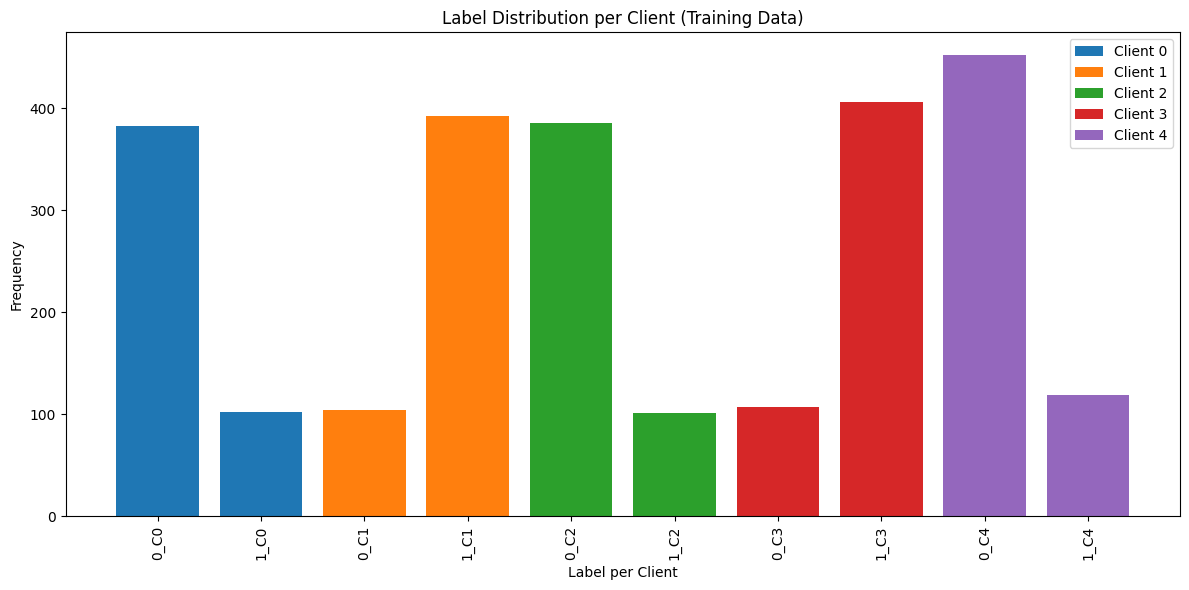

In [18]:
import matplotlib.pyplot as plt
from collections import Counter


def plot_label_distribution(clients):
    plt.figure(figsize=(12, 6))
    for idx, client in enumerate(clients):
        labels = [sample['label'] for epoch in client.data for sample in epoch]
        label_counts = Counter(labels)
        labels_sorted = sorted(label_counts.keys())
        counts = [label_counts[label] for label in labels_sorted]

        plt.bar(
            [str(label) + f"_C{idx}" for label in labels_sorted],
            counts,
            label=f'Client {idx}'
        )

    plt.xlabel("Label per Client")
    plt.ylabel("Frequency")
    plt.title("Label Distribution per Client (Training Data)")
    plt.xticks(rotation=90)
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_label_distribution(clients)


#Start Implementing Telepotation

In [19]:
import sys, importlib, qiskit
print("Python:", sys.version)
print("Qiskit version:", getattr(qiskit, "__version__", "unknown"))
print("qiskit_aer present?:", importlib.util.find_spec("qiskit_aer") is not None)
print("qiskit.providers.aer present?:", importlib.util.find_spec("qiskit.providers.aer") is not None)


Python: 3.12.11 (main, Jun  4 2025, 08:56:18) [GCC 11.4.0]
Qiskit version: 1.4.4
qiskit_aer present?: True
qiskit.providers.aer present?: False


In [20]:
%pip install -U qiskit-aer

# A. Implementing a Simplified Teleportation for a Single Parameter

Add a helper function (or functions) to encode and “teleport” one parameter. In a real implementation we would need to work with multi‑qubit circuits and extract continuous (analog) variables via state tomography. Here we simulate with a single‑qubit circuit where we assume that the parameter is recovered perfectly.

Without adding noise model run as follows.

Add noise model

In [21]:
# Teleportation utilities (Qiskit Aer, modern style)

from __future__ import annotations
import numpy as np
from typing import Optional, Literal
from qiskit import QuantumCircuit, ClassicalRegister
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, depolarizing_error
from qiskit.compiler import transpile
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt


def _build_noise_model(p1: float, p2: float) -> NoiseModel:
    """
    Depolarizing noise model: p1 for 1-qubit gates, p2 for 2-qubit gates.
    """
    nm = NoiseModel()
    nm.add_all_qubit_quantum_error(depolarizing_error(p1, 1), ['rx', 'rz', 'sx', 'x', 'h'])
    nm.add_all_qubit_quantum_error(depolarizing_error(p2, 2), ['cx'])
    return nm


def make_backend(noise: Literal['none','low','med','high']='none', shots: int=1024) -> AerSimulator:
    """
    Create (and reuse) a simulator backend with an optional depolarizing noise model.
    """
    if noise == 'none':
        return AerSimulator(shots=shots)
    elif noise == 'low':
        nm = _build_noise_model(p1=0.001, p2=0.005)
    elif noise == 'med':
        nm = _build_noise_model(p1=0.005, p2=0.015)
    elif noise == 'high':
        nm = _build_noise_model(p1=0.01,  p2=0.02)
    else:
        raise ValueError(f"unknown noise preset: {noise}")
    return AerSimulator(noise_model=nm, shots=shots)


def _teleport_circuit(theta: float) -> QuantumCircuit:
    """
    Standard 3-qubit teleportation circuit.
    Encodes parameter `theta` as an RX rotation on |ψ> (qubit 0).
    Measures two classical bits c0, c1 separately so we can condition X/Z.
    """
    qc = QuantumCircuit(3, name='teleport')

    # add two 1-bit classical registers for independent conditions
    c0 = ClassicalRegister(1, 'c0')
    c1 = ClassicalRegister(1, 'c1')
    qc.add_register(c0)
    qc.add_register(c1)

    # |ψ> on qubit 0
    qc.rx(theta, 0)

    # Create Bell pair between qubits 1 and 2
    qc.h(1)
    qc.cx(1, 2)

    # Bell-state measurement on qubits 0 and 1
    qc.cx(0, 1)
    qc.h(0)
    qc.measure(0, c0[0])   # first classical bit (Z correction flag)
    qc.measure(1, c1[0])   # second classical bit (X correction flag)

    # Conditional corrections on qubit 2
    qc.z(2).c_if(c0, 1)
    qc.x(2).c_if(c1, 1)
    return qc


def teleport_parameter(
    val: float,
    backend: Optional[AerSimulator]=None,
    noise: Literal['none','low','med','high']='none',
    shots: int = 1024,
    show_histogram: bool = False,
) -> float:
    """
    Teleport a single scalar encoded as RX(val) on the input qubit, through a Bell pair.

    Returns the *same* scalar `val` (we're not decoding a continuous value from counts here);
    use the histogram purely to verify teleportation behavior under noise.
    """
    if backend is None:
        backend = make_backend(noise=noise, shots=shots)

    qc = _teleport_circuit(val)
    tqc = transpile(qc, backend)
    result = backend.run(tqc).result()
    counts = result.get_counts()

    if show_histogram:
        plot_histogram(counts)
        plt.show()

    # For training-time efficiency we return the input value.
    # If  want to *distort* the parameter based on fidelity under noise,
    #  can map counts -> an effective angle here.
    return float(val)


def teleport_parameters(
    params: np.ndarray,
    backend: Optional[AerSimulator]=None,
    noise: Literal['none','low','med','high']='none',
    shots: int = 1024,
    show_histogram: bool = False,
) -> np.ndarray:
    """
    Teleport each parameter independently. Reuses the same backend for speed.
    """
    if backend is None:
        backend = make_backend(noise=noise, shots=shots)
    out = [teleport_parameter(p, backend=backend, noise=noise, shots=shots,
                              show_histogram=show_histogram) for p in np.asarray(params)]
    return np.asarray(out, dtype=np.float32)


In [22]:
'''
# ===== teleport_duqfl.py  (unified demo/perturb) =====
from __future__ import annotations
import numpy as np
from typing import Optional, Literal, Tuple, Dict, List

from qiskit import QuantumCircuit, ClassicalRegister
from qiskit.circuit import Parameter
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, depolarizing_error
from qiskit.compiler import transpile
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt


# ---------------- Noise presets ----------------
def _build_noise_model(p1: float, p2: float) -> NoiseModel:
    nm = NoiseModel()
    nm.add_all_qubit_quantum_error(depolarizing_error(p1, 1), ['rx','rz','sx','x','h'])
    nm.add_all_qubit_quantum_error(depolarizing_error(p2, 2), ['cx'])
    return nm

def make_backend(noise: Literal['none','low','med','high']='none', shots: int=1024) -> AerSimulator:
    if noise == 'none':
        return AerSimulator(shots=shots)
    elif noise == 'low':
        nm = _build_noise_model(0.001, 0.005)
    elif noise == 'med':
        nm = _build_noise_model(0.005, 0.015)
    elif noise == 'high':
        nm = _build_noise_model(0.01,  0.02)
    else:
        raise ValueError(f"unknown noise preset {noise!r}")
    return AerSimulator(noise_model=nm, shots=shots)

# -------------- Teleport circuit ---------------
def build_param_teleport_circuit() -> Tuple[QuantumCircuit, Parameter]:
    """Teleport RX(theta) from qubit-0 → qubit-2; measure c0,c1 (controls) and c2 (output)."""
    theta = Parameter('theta')
    qc = QuantumCircuit(3, name='teleport')
    c0 = ClassicalRegister(1, 'c0')  # Z control
    c1 = ClassicalRegister(1, 'c1')  # X control
    c2 = ClassicalRegister(1, 'c2')  # output bit
    qc.add_register(c0); qc.add_register(c1); qc.add_register(c2)

    qc.rx(theta, 0)
    qc.h(1); qc.cx(1, 2)
    qc.cx(0, 1); qc.h(0)
    qc.measure(0, c0[0]); qc.measure(1, c1[0])
    qc.z(2).c_if(c0, 1);  qc.x(2).c_if(c1, 1)
    qc.measure(2, c2[0])
    return qc, theta

# -------------- Decoding & stats ---------------
def _p1_from_counts_lastbit(counts: Dict[str,int]) -> float:
    n0 = n1 = 0
    for bs, c in counts.items():
        b = bs.replace(' ','')[-1]  # last bit is c2
        if b == '0': n0 += c
        elif b == '1': n1 += c
    tot = n0 + n1
    return 0.0 if tot == 0 else n1 / tot

def decode_angle_from_p1(p1: float) -> float:
    p1 = float(np.clip(p1, 0.0, 1.0))
    return float(2.0 * np.arcsin(np.sqrt(p1)))  # invert p1 = sin^2(theta/2)

def fidelity_proxy(theta_in: float, theta_out: float) -> float:
    # |<ψ(θ_in)|ψ(θ_out)>|^2, with |ψ(θ)>=cos(θ/2)|0>+sin(θ/2)|1>
    return float(np.cos(0.5 * (theta_out - theta_in))**2)

def shrinkage_from_fidelity(fid: np.ndarray, lo: float=0.70, hi: float=0.95) -> float:
    Fav = float(np.mean(np.clip(fid, 0.0, 1.0)))
    if Fav >= hi: return 1.0
    if Fav <= lo: return 0.0
    return (Fav - lo) / (hi - lo)

# -------------- Public API ---------------------
def teleport_parameters(
    params: np.ndarray,
    *,
    mode: Literal['demo','perturb']='demo',
    noise: Literal['none','low','med','high']='none',
    shots: int = 1024,
    backend: Optional[AerSimulator] = None,
    show_histogram: bool = False,
    apply_shrinkage: bool = True,
) -> Tuple[np.ndarray, dict]:
    """
    Teleport a parameter vector.

    mode='demo'    → run teleportation, optionally show histograms, return original params.
    mode='perturb' → decode output bit to effective angle θ′, compute Δθ and fidelity,
                     optionally apply fidelity-based shrinkage to Δθ, return θ̃ = θ + βΔθ.

    Returns:
      params_out : np.ndarray (same shape as params)
      info       : dict with keys {'theta_out','delta_tel','fidelity','beta','noise','shots'}
    """
    theta_in = np.asarray(params, dtype=float).reshape(-1)

    if backend is None:
        backend = make_backend(noise=noise, shots=shots)

    qc, theta_sym = build_param_teleport_circuit()
    tqc = transpile(qc, backend)

    theta_out, delta, fid = [], [], []
    circuits_to_run = []

    for t in theta_in:
        # Assign the parameter value to the transpiled circuit
        assigned_circuit = tqc.assign_parameters({theta_sym: t})
        circuits_to_run.append(assigned_circuit)


    job = backend.run(circuits_to_run)
    result = job.result()

    for idx, (t_in, res) in enumerate(zip(theta_in, result.results)):
        # Access counts directly from res.data
        counts = res.data.get('counts')
        if show_histogram:
            plot_histogram(counts); plt.show()

        p1 = _p1_from_counts_lastbit(counts)
        t_eff = decode_angle_from_p1(p1)
        theta_out.append(t_eff)
        delta.append(t_eff - t_in)
        fid.append(fidelity_proxy(t_in, t_eff))

    theta_out = np.asarray(theta_out, dtype=np.float32).reshape(params.shape)
    delta     = np.asarray(delta,     dtype=np.float32).reshape(params.shape)
    fid       = np.asarray(fid,       dtype=np.float32).reshape(params.shape)

    if mode == 'demo':
        return np.asarray(params, dtype=np.float32), {
            'theta_out': theta_out, 'delta_tel': delta, 'fidelity': fid,
            'beta': 0.0, 'noise': noise, 'shots': shots
        }

    # mode == 'perturb'
    beta = shrinkage_from_fidelity(fid) if apply_shrinkage else 1.0
    params_out = np.asarray(params, dtype=np.float32) + beta * delta
    return params_out, {
        'theta_out': theta_out, 'delta_tel': delta, 'fidelity': fid,
        'beta': beta, 'noise': noise, 'shots': shots
    }
    '''

    # ===== Teleportation utilities (perturbation-aware; assign_parameters; Aer V2) =====
from __future__ import annotations
import numpy as np
from typing import Optional, Literal, Tuple, Dict

from qiskit import QuantumCircuit, ClassicalRegister
from qiskit.circuit import Parameter
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, depolarizing_error
from qiskit.compiler import transpile
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt


# ---------------- Noise presets ----------------
def _build_noise_model(p1: float, p2: float) -> NoiseModel:
    nm = NoiseModel()
    nm.add_all_qubit_quantum_error(depolarizing_error(p1, 1), ['rx','rz','sx','x','h'])
    nm.add_all_qubit_quantum_error(depolarizing_error(p2, 2), ['cx'])
    return nm

def make_backend(noise: Literal['none','low','med','high']='none', shots: int=1024) -> AerSimulator:
    if noise == 'none':
        return AerSimulator(shots=shots)
    elif noise == 'low':
        nm = _build_noise_model(0.001, 0.005)
    elif noise == 'med':
        nm = _build_noise_model(0.005, 0.015)
    elif noise == 'high':
        nm = _build_noise_model(0.01,  0.02)
    else:
        raise ValueError(f"unknown noise preset {noise!r}")
    return AerSimulator(noise_model=nm, shots=shots)

# -------------- Parameterized teleport circuit ---------------
def build_param_teleport_circuit() -> Tuple[QuantumCircuit, Parameter]:
    """Teleport RX(theta) from qubit-0 to qubit-2; measure c0,c1 (controls) and c2 (output)."""
    theta = Parameter('theta')
    qc = QuantumCircuit(3, name='teleport')

    c0 = ClassicalRegister(1, 'c0')  # Z control bit
    c1 = ClassicalRegister(1, 'c1')  # X control bit
    c2 = ClassicalRegister(1, 'c2')  # output bit (teleported qubit)
    qc.add_register(c0); qc.add_register(c1); qc.add_register(c2)

    qc.rx(theta, 0)
    qc.h(1); qc.cx(1, 2)
    qc.cx(0, 1); qc.h(0)
    qc.measure(0, c0[0]); qc.measure(1, c1[0])
    qc.z(2).c_if(c0, 1);  qc.x(2).c_if(c1, 1)
    qc.measure(2, c2[0])
    return qc, theta

# -------------- Decoding & shrinkage ---------------
def _p1_from_counts_lastbit(counts: Dict[str,int]) -> float:
    """Return P(measure '1' on the LAST classical bit (c2))."""
    n0 = n1 = 0
    for bs, c in counts.items():
        b = bs.replace(' ','')[-1]  # last bit corresponds to c2
        if b == '0': n0 += c
        elif b == '1': n1 += c
    tot = n0 + n1
    return 0.0 if tot == 0 else n1 / tot

def _decode_angle_from_p1(p1: float) -> float:
    # invert p1 = sin^2(theta/2)
    p1 = float(np.clip(p1, 0.0, 1.0))
    return float(2.0 * np.arcsin(np.sqrt(p1)))

def _fidelity_proxy(theta_in: float, theta_out: float) -> float:
    # |<ψ(θ_in)|ψ(θ_out)>|^2 with |ψ(θ)>=cos(θ/2)|0>+sin(θ/2)|1>
    return float(np.cos(0.5 * (theta_out - theta_in))**2)

def _shrinkage_from_fidelity(fid: np.ndarray, lo: float=0.70, hi: float=0.95) -> float:
    Fav = float(np.mean(np.clip(fid, 0.0, 1.0)))
    if Fav >= hi: return 1.0
    if Fav <= lo: return 0.0
    return (Fav - lo) / (hi - lo)

# -------------- Public API (demo or perturb) ---------------
def teleport_parameters(
    params: np.ndarray,
    *,
    mode: Literal['demo','perturb']='demo',
    noise: Literal['none','low','med','high']='none',
    shots: int = 1024,
    backend: Optional[AerSimulator] = None,
    show_histogram: bool = False,
    apply_shrinkage: bool = True,
):
    """
    mode='demo'    → run teleportation (optionally noisy), return params unchanged.
    mode='perturb' → decode counts to effective RX angles θ', compute Δ=θ'-θ,
                     (optionally) apply fidelity-weighted shrinkage, and return θ̃=θ+βΔ.

    Returns:
        params_out : np.ndarray
        info       : dict with {theta_out, delta_tel, fidelity, beta, noise, shots}
    """
    theta_in = np.asarray(params, dtype=float).reshape(-1)

    if backend is None:
        backend = make_backend(noise=noise, shots=shots)

    qc, theta_sym = build_param_teleport_circuit()
    tqc = transpile(qc, backend)

    # Backward-compatible parameter binding (assign_parameters)
    circuits = [tqc.assign_parameters({theta_sym: t}, inplace=False) for t in theta_in]
    job = backend.run(circuits)
    result = job.result()

    theta_out, delta, fid = [], [], []
    for i, t_in in enumerate(theta_in):
        # Robust way to get counts from the i-th experiment:
        counts = result.get_counts(i)  # <-- FIX: use Result API, not res.data.get(...)
        if show_histogram:
            plot_histogram(counts); plt.show()

        p1 = _p1_from_counts_lastbit(counts)
        t_eff = _decode_angle_from_p1(p1)
        theta_out.append(t_eff)
        delta.append(t_eff - t_in)
        fid.append(_fidelity_proxy(t_in, t_eff))

    theta_out = np.asarray(theta_out, dtype=np.float32).reshape(params.shape)
    delta     = np.asarray(delta,     dtype=np.float32).reshape(params.shape)
    fid       = np.asarray(fid,       dtype=np.float32).reshape(params.shape)

    if mode == 'demo':
        return np.asarray(params, dtype=np.float32), {
            'theta_out': theta_out, 'delta_tel': delta, 'fidelity': fid,
            'beta': 0.0, 'noise': noise, 'shots': shots
        }

    # mode == 'perturb'
    beta = _shrinkage_from_fidelity(fid) if apply_shrinkage else 1.0
    params_out = np.asarray(params, dtype=np.float32) + beta * delta
    return params_out, {
        'theta_out': theta_out, 'delta_tel': delta, 'fidelity': fid,
        'beta': beta, 'noise': noise, 'shots': shots
    }


Implement entanglement

#B. Integrating Teleportation into the Federated Learning Loop
Within our federated learning loop, once we have determined the best client's model and before updating all clients, implement to “teleport” the model’s parameter update.

#More  implement ->error correction, state tomography, and the complications of multi‑qubit encoding.

In [25]:
# ========= METRICS LOGGER: init =========
metrics = metrics_init(log_path="/content/drive/MyDrive/Teleportation/No_NoIID_teleport_metrics_Perturb_shrink.csv")

# keep handy trackers for plots
_rounds = []
_global_acc = []
_val_losses = []
_round_times_plot = []
_fidelity_means = []
_betas = []
_delta_acc = []   # per-round change in global accuracy

# if you track noise/alpha externally, set these; otherwise keep simple
noise_preset = 'med'   # or the variable you use
shots_used = 256


Federated Learning Setup

Client 1:
  Epoch 1: Train data samples: 41
  Epoch 2: Train data samples: 28
  Epoch 3: Train data samples: 64
  Epoch 4: Train data samples: 68
  Epoch 5: Train data samples: 41
  Epoch 6: Train data samples: 39
  Epoch 7: Train data samples: 65
  Epoch 8: Train data samples: 36
  Epoch 9: Train data samples: 71
  Epoch 10: Train data samples: 32
  Test data samples: 1000
Client 2:
  Epoch 1: Train data samples: 36
  Epoch 2: Train data samples: 45
  Epoch 3: Train data samples: 66
  Epoch 4: Train data samples: 64
  Epoch 5: Train data samples: 38
  Epoch 6: Train data samples: 62
  Epoch 7: Train data samples: 51
  Epoch 8: Train data samples: 34
  Epoch 9: Train data samples: 61
  Epoch 10: Train data samples: 40
  Test data samples: 1000
Client 3:
  Epoch 1: Train data samples: 72
  Epoch 2: Train data samples: 37
  Epoch 3: Train data samples: 37
  Epoch 4: Train data samples: 37
  Epoch 5: Train data samples: 74
  Epoch 6: Train data samples: 44
  Epoch 7: Train data samples: 4

Training Progress:   0%|          | 0/10 [00:00<?, ?it/s]



Fed_Epoch: 0


Fed_Epoch 0, Client 1:
Training data for epoch 0: 41
Client Data Structure:
[{'sequence': array([0.26664435, 0.26664435, 0.26664435, 0.26664435, 0.26664435]), 'label': 0}, {'sequence': array([0.34030203, 0.34030203, 0.34030203, 0.34030203, 0.34030203]), 'label': 0}, {'sequence': array([0.38961695, 0.38961695, 0.38961695, 0.38961695, 0.38961695]), 'label': 0}, {'sequence': array([0.27311765, 0.27311765, 0.27311765, 0.27311765, 0.27311765]), 'label': 0}, {'sequence': array([0.12901503, 0.12901503, 0.12901503, 0.12901503, 0.12901503]), 'label': 0}, {'sequence': array([0.38647879, 0.38647879, 0.38647879, 0.38647879, 0.38647879]), 'label': 0}, {'sequence': array([0.21228937, 0.21228937, 0.21228937, 0.21228937, 0.21228937]), 'label': 0}, {'sequence': array([0.18928737, 0.18928737, 0.18928737, 0.18928737, 0.18928737]), 'label': 0}, {'sequence': array([0.46864364, 0.46864364, 0.46864364, 0.46864364, 0.46864364]), 'label': 0}, {'sequence': array([0.15444263, 0.15444263, 0.15444

/tmp/ipython-input-4270557481.py:16: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  sampler_qnn = SamplerQNN(


Trained parameters after iteration 1: [0.11077986 0.53971146 0.71547354 0.58347945 0.28144026 0.53931441
 0.64933421 0.68992436 0.76086362 0.10453951 0.69286438 0.14841835
 0.20420571 0.08554535 0.29303422 0.84307846 0.67922623 0.11778792
 0.83933948 0.25056415]
Iteration 1 - Learning Rate: 0.216785
Iteration 1 - Training Accuracy: 0.66
Iteration 1 - Test Accuracy: 0.48


Deep Unfolding Iteration 2/5
Trained parameters after iteration 2: [-0.04804487  0.47738878  0.63448396  0.52357449  0.17296418  0.53128631
  0.73706565  0.71293514  0.62724598  0.01721528  0.65019783  0.19716691
  0.18661755 -0.06227923  0.09443037  0.7107316   0.51155863  0.06087474
  0.71246598  0.15740359]
Iteration 2 - Learning Rate: 0.292933
Iteration 2 - Training Accuracy: 0.71
Iteration 2 - Test Accuracy: 0.49


Deep Unfolding Iteration 3/5
Trained parameters after iteration 3: [-0.00420495  0.53154045  0.62331889  0.49141958  0.04939268  0.53216516
  0.75652547  0.71154654  0.64868968 -0.00706776  0.67202704 

/tmp/ipython-input-4270557481.py:16: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  sampler_qnn = SamplerQNN(


Trained parameters after iteration 1: [ 0.16886909  0.49597354  0.88641449  0.69633126  0.7407308   0.69890305
  0.6479683   0.02878497  0.10011026  1.24090504  0.55383026  0.50386173
  0.07602325 -0.02939311  0.96446907  0.05679504  0.50352907  0.34640287
  0.20887291  0.4738057 ]
Iteration 1 - Learning Rate: 0.210561
Iteration 1 - Training Accuracy: 0.78
Iteration 1 - Test Accuracy: 0.54


Deep Unfolding Iteration 2/5
Trained parameters after iteration 2: [ 0.08832208  0.44232481  0.97824572  0.73534138  0.64724566  0.74230298
  0.7469566   0.10547938  0.07302309  1.34896559  0.5349058   0.56693976
  0.06914059 -0.14822399  1.09314923 -0.00170492  0.42598654  0.33471428
  0.19063642  0.55684904]
Iteration 2 - Learning Rate: 0.269864
Iteration 2 - Training Accuracy: 0.78
Iteration 2 - Test Accuracy: 0.52


Deep Unfolding Iteration 3/5
Trained parameters after iteration 3: [ 0.01016601  0.38911724  0.95180672  0.71670689  0.67726444  0.62113218
  0.8120986   0.20066952  0.10130417  1.4

/tmp/ipython-input-4270557481.py:16: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  sampler_qnn = SamplerQNN(


Trained parameters after iteration 1: [ 0.49265602  1.23450513  0.50158306  0.45534368 -0.20553281  0.77536193
  0.43573162  0.94143621  0.04026928  0.36403169  0.65447786  0.94989065
  0.12667701 -0.09038495  0.70821958  0.47874735  0.40820529  0.47312062
  0.67034935 -0.03112026]
Iteration 1 - Learning Rate: 0.211208
Iteration 1 - Training Accuracy: 0.79
Iteration 1 - Test Accuracy: 0.63


Deep Unfolding Iteration 2/5
Trained parameters after iteration 2: [ 0.5253514   1.08105593  0.4382709   0.38040735 -0.29253951  0.62295884
  0.35687733  0.92193752  0.13791169  0.1649626   0.47530564  0.94799215
  0.10149649 -0.11654432  0.51270042  0.3744543   0.20696648  0.41173483
  0.59760016 -0.1527521 ]
Iteration 2 - Learning Rate: 0.300033
Iteration 2 - Training Accuracy: 0.78
Iteration 2 - Test Accuracy: 0.59


Deep Unfolding Iteration 3/5
Trained parameters after iteration 3: [ 0.49754402  1.08506942  0.48987024  0.2746347  -0.33663337  0.54704394
  0.47175546  0.93581865  0.21376733  0.0

/tmp/ipython-input-4270557481.py:16: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  sampler_qnn = SamplerQNN(


Trained parameters after iteration 1: [0.7173116  0.95447379 0.72346512 0.92173572 0.43340112 0.23163726
 0.31278249 0.01115847 0.32343276 0.43234283 0.49881761 0.03202474
 0.19699023 0.17433666 0.39259584 0.3728243  0.89975936 0.17401029
 0.72405098 1.04890725]
Iteration 1 - Learning Rate: 0.217918
Iteration 1 - Training Accuracy: 0.40
Iteration 1 - Test Accuracy: 0.47


Deep Unfolding Iteration 2/5
Trained parameters after iteration 2: [ 0.54927509  0.87940886  0.77499439  0.85646452  0.67153387  0.07210712
  0.48886323 -0.16922933  0.20781075  0.50175812  0.67266437  0.10491451
  0.0970077  -0.26507615  0.56806545  0.50732561  0.47038406  0.11981744
  0.74164438  1.3276306 ]
Iteration 2 - Learning Rate: 0.322645
Iteration 2 - Training Accuracy: 0.76
Iteration 2 - Test Accuracy: 0.54


Deep Unfolding Iteration 3/5
Trained parameters after iteration 3: [ 0.50613651  0.84047655  0.7562732   0.92434634  0.55264342 -0.08545854
  0.66602906  0.02326626  0.12105561  0.69454054  0.79861961 

/tmp/ipython-input-4270557481.py:16: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  sampler_qnn = SamplerQNN(


Trained parameters after iteration 1: [ 0.49939202  0.34897516 -0.11809846  0.35386888  0.30171234 -0.01497925
  0.83766673  0.91496134  0.38250798  1.08812683  0.59477266  0.29990547
  0.04696512  0.7197298   0.99986025  0.2842014   0.56788777  0.89199119
  0.90328927  1.00710722]
Iteration 1 - Learning Rate: 0.227403
Iteration 1 - Training Accuracy: 0.78
Iteration 1 - Test Accuracy: 0.60


Deep Unfolding Iteration 2/5
Trained parameters after iteration 2: [ 0.18505952  0.46571525 -0.2716183   0.40869104  0.11109944 -0.00894352
  0.74993591  0.97238369  0.43045394  1.04316862  0.71919101  0.38050906
 -0.11315511  0.93140586  0.87121511  0.05115613  0.3133213   0.7614588
  0.906836    1.26802663]
Iteration 2 - Learning Rate: 0.333839
Iteration 2 - Training Accuracy: 0.80
Iteration 2 - Test Accuracy: 0.51


Deep Unfolding Iteration 3/5
Trained parameters after iteration 3: [ 0.06809897  0.44832592 -0.36035666  0.53882751  0.19085293 -0.02339554
  0.90448277  0.86249105  0.54842701  1.01

Training Progress:  10%|█         | 1/10 [14:17<2:08:37, 857.53s/it]

After round 0, central val loss = 0.8166

File saved to /content/drive/MyDrive/Teleportation/Noise_No_Tele_DQFL_MediumNoise_Genome_non_IID_Global_23_09_2025_NoTeleport_WithNoise_clients5_layers10_du5_lr0p15_pert0p15.csv


Fed_Epoch: 1


Fed_Epoch 1, Client 1:
Training data for epoch 1: 28
Client Data Structure:
[{'sequence': array([0.40466699, 0.40466699, 0.40466699, 0.40466699, 0.40466699]), 'label': 0}, {'sequence': array([0.00724484, 0.00724484, 0.00724484, 0.00724484, 0.00724484]), 'label': 0}, {'sequence': array([0.06148699, 0.06148699, 0.06148699, 0.06148699, 0.06148699]), 'label': 0}, {'sequence': array([0.05703149, 0.05703149, 0.05703149, 0.05703149, 0.05703149]), 'label': 0}, {'sequence': array([0.04407788, 0.04407788, 0.04407788, 0.04407788, 0.04407788]), 'label': 0}, {'sequence': array([0.15430442, 0.15430442, 0.15430442, 0.15430442, 0.15430442]), 'label': 0}, {'sequence': array([0.15566677, 0.15566677, 0.15566677, 0.15566677, 0.15566677]), 'label': 0}, {'sequence': array([0

/tmp/ipython-input-4270557481.py:16: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  sampler_qnn = SamplerQNN(


Trained parameters after iteration 1: [-0.16787816  0.91419464  1.12465792  0.2777216   0.28034771  0.47711132
  0.53451293  0.97756027  0.59582965  0.15484405  0.54877718  0.80700913
  0.15805542  0.91258935  0.04622083  0.51762241  0.56593166  0.06493994
  0.87640672  0.88341635]
Iteration 1 - Learning Rate: 0.210705
Iteration 1 - Training Accuracy: 0.75
Iteration 1 - Test Accuracy: 0.48


Deep Unfolding Iteration 2/5
Trained parameters after iteration 2: [-0.15837987  1.03617889  0.99633573  0.31086182  0.325467    0.62206287
  0.65321788  0.90868532  0.53140862  0.03594824  0.5391343   0.77816954
  0.20992409  1.1418315  -0.12446132  0.37647258  0.56664754  0.00876816
  0.90574461  0.99741803]
Iteration 2 - Learning Rate: 0.287602
Iteration 2 - Training Accuracy: 0.79
Iteration 2 - Test Accuracy: 0.48


Deep Unfolding Iteration 3/5
Trained parameters after iteration 3: [-0.15982189  1.08500349  0.92920997  0.38728614  0.35922919  0.5583622
  0.70789813  0.85181045  0.54888616  0.05

/tmp/ipython-input-4270557481.py:16: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  sampler_qnn = SamplerQNN(


Trained parameters after iteration 1: [ 0.51616541  0.22073306  0.39143343  0.89956978  0.69305656  0.24086715
  0.97111339  0.87696829  0.6146973   1.33326515  0.29249606  0.02105697
  0.0124868   0.39495764  1.14823894  0.25652504  0.27917257 -0.03035142
  0.92378133  0.03448535]
Iteration 1 - Learning Rate: 0.214629
Iteration 1 - Training Accuracy: 0.89
Iteration 1 - Test Accuracy: 0.62


Deep Unfolding Iteration 2/5
Trained parameters after iteration 2: [ 0.51084649  0.19535056  0.41389913  0.9307479   0.63385727  0.29415008
  1.02771092  0.89689905  0.51114247  1.38503664  0.29210943  0.13215884
 -0.06280531  0.33202538  1.31005884  0.10980285  0.17163866 -0.03045745
  0.84763556 -0.02124151]
Iteration 2 - Learning Rate: 0.282002
Iteration 2 - Training Accuracy: 0.87
Iteration 2 - Test Accuracy: 0.60


Deep Unfolding Iteration 3/5
Trained parameters after iteration 3: [ 0.62693982  0.1990381   0.40481509  0.90496095  0.57981655  0.29038575
  1.07718021  0.89787581  0.42748724  1.3

/tmp/ipython-input-4270557481.py:16: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  sampler_qnn = SamplerQNN(


Trained parameters after iteration 1: [ 0.51199559  0.83830248  0.06144591  0.17890532  0.81250484  1.00510721
  0.82724549  0.39359073  0.64258159  0.5872082   0.16141316  0.40845352
  0.04268717  0.29468368 -0.27304406  0.63809466  0.8754499   0.14983786
  0.15588187 -0.00692556]
Iteration 1 - Learning Rate: 0.209008
Iteration 1 - Training Accuracy: 0.78
Iteration 1 - Test Accuracy: 0.48


Deep Unfolding Iteration 2/5
Trained parameters after iteration 2: [ 0.4545586   0.66705921  0.21170393  0.05928762  0.74900194  1.01798898
  0.89812858  0.35086344  0.54144236  0.47859094  0.1925344   0.37432924
 -0.07393491  0.11192619 -0.40745224  0.45714981  0.78340178  0.09686291
  0.30789245 -0.31991541]
Iteration 2 - Learning Rate: 0.294896
Iteration 2 - Training Accuracy: 0.78
Iteration 2 - Test Accuracy: 0.48


Deep Unfolding Iteration 3/5
Trained parameters after iteration 3: [ 0.41934545  0.58402227  0.20606738  0.0145201   0.6080238   1.05506693
  0.95472668  0.33722599  0.54398374  0.4

/tmp/ipython-input-4270557481.py:16: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  sampler_qnn = SamplerQNN(


Trained parameters after iteration 1: [0.13543613 0.25444811 0.65974516 0.84686484 0.4314225  0.48205652
 0.42045073 0.53162569 1.08054168 0.24854251 0.77189885 0.84572805
 0.38879239 0.92410734 1.14207413 0.03323855 0.64223213 0.61418633
 0.85420775 0.62204987]
Iteration 1 - Learning Rate: 0.229713
Iteration 1 - Training Accuracy: 0.81
Iteration 1 - Test Accuracy: 0.61


Deep Unfolding Iteration 2/5
Trained parameters after iteration 2: [0.11812942 0.42411709 0.82461917 0.74960037 0.34814167 0.65273778
 0.30346316 0.50843611 0.95620696 0.14989888 0.93224078 0.74340545
 0.60100413 1.02764589 1.45353375 0.11474738 0.66090931 0.61280807
 0.79571138 0.52681014]
Iteration 2 - Learning Rate: 0.324236
Iteration 2 - Training Accuracy: 0.77
Iteration 2 - Test Accuracy: 0.54


Deep Unfolding Iteration 3/5
Trained parameters after iteration 3: [0.06443651 0.23702307 0.91229053 0.59011832 0.20270026 0.71224337
 0.18889851 0.5789132  0.96453746 0.20366394 1.02659919 0.7296942
 0.52327856 1.1718620

/tmp/ipython-input-4270557481.py:16: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  sampler_qnn = SamplerQNN(


Trained parameters after iteration 1: [0.00570135 0.71358058 0.14315625 0.96006661 0.80065286 0.16966569
 0.09104818 0.29826108 0.18947576 0.50044791 0.34475626 0.83325634
 0.19530522 0.33712247 0.74021713 0.25344755 0.33984571 0.16470289
 1.08448281 0.46790328]
Iteration 1 - Learning Rate: 0.227143
Iteration 1 - Training Accuracy: 0.89
Iteration 1 - Test Accuracy: 0.72


Deep Unfolding Iteration 2/5
Trained parameters after iteration 2: [-0.19135548  0.78150311  0.05764099  1.10814536  0.69051712  0.13116801
 -0.02351182  0.27526101  0.35686203  0.4067211   0.31131697  0.90933974
  0.19441557  0.41864165  0.47990577  0.13037473  0.39154064  0.2361618
  0.96952038  0.64918988]
Iteration 2 - Learning Rate: 0.310709
Iteration 2 - Training Accuracy: 0.90
Iteration 2 - Test Accuracy: 0.69


Deep Unfolding Iteration 3/5
Trained parameters after iteration 3: [-0.16555393  0.89646122  0.11737961  1.19383495  0.58822728  0.12806097
 -0.06152372  0.34193932  0.46229724  0.38215363  0.26787122  

Training Progress:  20%|██        | 2/10 [25:49<1:41:22, 760.31s/it]

After round 1, central val loss = 0.6937

File saved to /content/drive/MyDrive/Teleportation/Noise_No_Tele_DQFL_MediumNoise_Genome_non_IID_Global_23_09_2025_NoTeleport_WithNoise_clients5_layers10_du5_lr0p15_pert0p15.csv


Fed_Epoch: 2


Fed_Epoch 2, Client 1:
Training data for epoch 2: 64
Client Data Structure:
[{'sequence': array([0.47739918, 0.47739918, 0.47739918, 0.47739918, 0.47739918]), 'label': 0}, {'sequence': array([0.24413293, 0.24413293, 0.24413293, 0.24413293, 0.24413293]), 'label': 0}, {'sequence': array([0.10170379, 0.10170379, 0.10170379, 0.10170379, 0.10170379]), 'label': 0}, {'sequence': array([0.03405305, 0.03405305, 0.03405305, 0.03405305, 0.03405305]), 'label': 0}, {'sequence': array([0.01594754, 0.01594754, 0.01594754, 0.01594754, 0.01594754]), 'label': 0}, {'sequence': array([0.42228235, 0.42228235, 0.42228235, 0.42228235, 0.42228235]), 'label': 0}, {'sequence': array([0.36951496, 0.36951496, 0.36951496, 0.36951496, 0.36951496]), 'label': 0}, {'sequence': array([0

/tmp/ipython-input-4270557481.py:16: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  sampler_qnn = SamplerQNN(


Trained parameters after iteration 1: [ 0.8704643   0.42356272  0.01345859  0.67687451  0.42576934  0.72124828
  0.73747563  0.78805225 -0.00480924 -0.12129277  0.00880649 -0.00500475
  0.76750933  0.26827698 -0.13082233  0.58889653  0.96289031  0.27665496
  0.5708352   0.71753608]
Iteration 1 - Learning Rate: 0.208438
Iteration 1 - Training Accuracy: 0.80
Iteration 1 - Test Accuracy: 0.49


Deep Unfolding Iteration 2/5
Trained parameters after iteration 2: [ 0.78410709  0.52305677 -0.01561375  0.64731296  0.47818295  0.7236433
  0.86789353  0.83622749  0.0736688  -0.13771059  0.0808949  -0.09155632
  0.80282846  0.21297267 -0.26136649  0.50185785  1.02823817  0.35948228
  0.41665611  0.64739917]
Iteration 2 - Learning Rate: 0.278124
Iteration 2 - Training Accuracy: 0.80
Iteration 2 - Test Accuracy: 0.49


Deep Unfolding Iteration 3/5
Trained parameters after iteration 3: [ 0.78957374  0.58256386 -0.0655386   0.62515789  0.45682466  0.81872807
  0.86183723  0.77544851  0.05813162 -0.23

/tmp/ipython-input-4270557481.py:16: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  sampler_qnn = SamplerQNN(


Trained parameters after iteration 1: [ 0.37425598  0.52887771 -0.05054781  0.02029928  0.09363728  0.7117115
  0.36125233  0.78643096  0.61387194  1.07320677  0.30857893  0.81924691
  0.88000422  0.18741783  0.58307805  0.218982    0.79164359  0.24234296
  0.74272597  0.91046401]
Iteration 1 - Learning Rate: 0.209051
Iteration 1 - Training Accuracy: 0.79
Iteration 1 - Test Accuracy: 0.55


Deep Unfolding Iteration 2/5
Trained parameters after iteration 2: [ 0.30836252  0.41945792 -0.0381518   0.05865426  0.0616735   0.76040901
  0.44090852  0.82468941  0.40494508  1.14760229  0.10902296  0.74230203
  1.05566394 -0.09975162  0.71934027  0.33995266  0.53333968  0.31294055
  0.74835619  1.01857191]
Iteration 2 - Learning Rate: 0.294812
Iteration 2 - Training Accuracy: 0.79
Iteration 2 - Test Accuracy: 0.52


Deep Unfolding Iteration 3/5
Trained parameters after iteration 3: [ 0.32101287  0.28535207 -0.04743189  0.08326091 -0.01609767  0.79971247
  0.38981241  0.95535742  0.37789642  1.30

/tmp/ipython-input-4270557481.py:16: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  sampler_qnn = SamplerQNN(


Trained parameters after iteration 1: [ 0.53199574 -0.11588937  0.10776078  1.24730726  0.74672224  0.71323137
  0.22558212 -0.28383664  0.634293    0.68248033  0.61664068  1.09442852
  0.50999208  0.35484031  0.12383705 -0.03908517  0.3349701   0.47672571
  0.76369267  0.3128644 ]
Iteration 1 - Learning Rate: 0.228494
Iteration 1 - Training Accuracy: 0.81
Iteration 1 - Test Accuracy: 0.60


Deep Unfolding Iteration 2/5
Trained parameters after iteration 2: [ 0.44511347 -0.04925482  0.1090039   1.28596059  0.7759128   0.82036295
  0.21617555 -0.34896703  0.80922618  0.70512813  0.60283615  1.26778197
  0.54957291  0.50501967 -0.07793837 -0.19057472  0.42630619  0.46233929
  0.6031982   0.56624824]
Iteration 2 - Learning Rate: 0.311152
Iteration 2 - Training Accuracy: 0.78
Iteration 2 - Test Accuracy: 0.48


Deep Unfolding Iteration 3/5
Trained parameters after iteration 3: [ 0.3864035   0.07292104  0.05412689  1.39017887  0.71202275  0.80351965
  0.26008506 -0.48090209  0.79627432  0.6

/tmp/ipython-input-4270557481.py:16: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  sampler_qnn = SamplerQNN(


Trained parameters after iteration 1: [ 0.16478885  0.25068089 -0.04365619  0.82665985  0.73478409  0.74382635
 -0.06487176  0.05197851  0.1435945   0.66975512  0.05641116  0.53325642
  0.49467074  0.01156623  0.99155258  0.37065393  0.51628347  1.02101024
  0.38045152  0.06651779]
Iteration 1 - Learning Rate: 0.209868
Iteration 1 - Training Accuracy: 0.83
Iteration 1 - Test Accuracy: 0.59


Deep Unfolding Iteration 2/5
Trained parameters after iteration 2: [ 0.04615337  0.23575456 -0.0175735   0.82071027  0.76791207  0.57869822
  0.06598768 -0.16942051  0.164219    0.96662551 -0.09902507  0.57482444
  0.35985688  0.06984714  1.22928788  0.14820276  0.4950229   0.868843
  0.20549262  0.19739987]
Iteration 2 - Learning Rate: 0.284720
Iteration 2 - Training Accuracy: 0.81
Iteration 2 - Test Accuracy: 0.57


Deep Unfolding Iteration 3/5
Trained parameters after iteration 3: [-0.06122895  0.25868052  0.07590582  0.71389976  0.70001668  0.46466677
  0.08177314 -0.22011858  0.02842444  1.197

/tmp/ipython-input-4270557481.py:16: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  sampler_qnn = SamplerQNN(


Trained parameters after iteration 1: [ 0.6409449   0.03077603  0.76372911  0.36825767  0.01621779  0.39188426
  0.0844819  -0.10075086  0.39930576  0.23044375  0.89428843  0.37469167
  0.69636076  0.25132089 -0.00258838  0.06842687  1.05240113  0.08670278
  0.7264557   0.69355224]
Iteration 1 - Learning Rate: 0.214483
Iteration 1 - Training Accuracy: 0.81
Iteration 1 - Test Accuracy: 0.55


Deep Unfolding Iteration 2/5
Trained parameters after iteration 2: [ 0.54950018  0.13525408  0.68051569  0.50231127  0.1160387   0.33066281
  0.0319747  -0.30362377  0.43413705  0.17590162  0.79771969  0.23014611
  0.70464922  0.16613273 -0.09129829  0.04437463  0.74182951  0.0304759
  0.47256513  0.49391153]
Iteration 2 - Learning Rate: 0.296734
Iteration 2 - Training Accuracy: 0.85
Iteration 2 - Test Accuracy: 0.52


Deep Unfolding Iteration 3/5
Trained parameters after iteration 3: [ 5.30436752e-01  1.63456375e-01  3.67598950e-01  3.27671906e-01
  6.03655074e-02  4.77085312e-01 -6.96551741e-02 -

Training Progress:  30%|███       | 3/10 [39:56<1:33:19, 799.98s/it]

After round 2, central val loss = 0.7268

File saved to /content/drive/MyDrive/Teleportation/Noise_No_Tele_DQFL_MediumNoise_Genome_non_IID_Global_23_09_2025_NoTeleport_WithNoise_clients5_layers10_du5_lr0p15_pert0p15.csv


Fed_Epoch: 3


Fed_Epoch 3, Client 1:
Training data for epoch 3: 68
Client Data Structure:
[{'sequence': array([0.10776203, 0.10776203, 0.10776203, 0.10776203, 0.10776203]), 'label': 0}, {'sequence': array([0.25344578, 0.25344578, 0.25344578, 0.25344578, 0.25344578]), 'label': 0}, {'sequence': array([0.19503405, 0.19503405, 0.1950331 , 0.1950331 , 0.1950331 ]), 'label': 0}, {'sequence': array([0.42838973, 0.42838973, 0.42838973, 0.42838973, 0.42838973]), 'label': 0}, {'sequence': array([0.42473535, 0.42473535, 0.42473535, 0.42473535, 0.42473535]), 'label': 0}, {'sequence': array([0.05858277, 0.05858277, 0.05858277, 0.05858277, 0.05858277]), 'label': 0}, {'sequence': array([1.44946054e-05, 1.15956843e-05, 8.69676322e-06, 5.79784214e-06,
       2.89892107e-06]), 'label'

/tmp/ipython-input-4270557481.py:16: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  sampler_qnn = SamplerQNN(


Trained parameters after iteration 1: [ 0.8855606   0.73062166  0.16168202  0.86868444  0.46227624  0.82358973
  0.79363988  0.31523759  0.61151732  0.24570315  0.65184702  0.83608422
  0.55581056  1.08541315  0.49606279 -0.13164255  0.06610808  0.34299922
  0.32080778  0.67667004]
Iteration 1 - Learning Rate: 0.205749
Iteration 1 - Training Accuracy: 0.79
Iteration 1 - Test Accuracy: 0.48


Deep Unfolding Iteration 2/5
Trained parameters after iteration 2: [ 0.97116806  0.72436563  0.16449932  1.09798543  0.23623443  0.6976176
  0.86004199  0.20142214  0.67956578  0.08304407  0.54727615  0.83206095
  0.40666601  1.40703913  0.38042016 -0.23296057 -0.0493016   0.15601471
  0.21448067  0.69323324]
Iteration 2 - Learning Rate: 0.306685
Iteration 2 - Training Accuracy: 0.79
Iteration 2 - Test Accuracy: 0.48


Deep Unfolding Iteration 3/5
Trained parameters after iteration 3: [ 0.9468751   0.7364721   0.21337076  1.02224485  0.24759023  0.65114895
  0.84776269  0.14708465  0.70923868  0.06

/tmp/ipython-input-4270557481.py:16: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  sampler_qnn = SamplerQNN(


Trained parameters after iteration 1: [ 0.67894541 -0.03128036  0.50029436  0.11713697  0.26998338  0.70600649
  1.00312619  0.28159336 -0.19984304  1.07231455  0.08135664  0.04212854
  0.4407488   0.30388729  0.41904693  0.34404583  0.68451641  0.39673407
  0.92573406  0.81594844]
Iteration 1 - Learning Rate: 0.217710
Iteration 1 - Training Accuracy: 0.81
Iteration 1 - Test Accuracy: 0.52


Deep Unfolding Iteration 2/5
Trained parameters after iteration 2: [ 0.61882069 -0.04475879  0.51041973 -0.0791463   0.32231205  0.70657868
  1.01366148  0.21909682 -0.29581693  1.32631912  0.05665716 -0.08577977
  0.38515128  0.07172831  0.60942272  0.15065151  0.66208596  0.32179301
  0.98132784  0.8469021 ]
Iteration 2 - Learning Rate: 0.302979
Iteration 2 - Training Accuracy: 0.81
Iteration 2 - Test Accuracy: 0.52


Deep Unfolding Iteration 3/5
Trained parameters after iteration 3: [ 0.70847988  0.01214229  0.34257337 -0.11349468  0.13769651  0.6369004
  0.9762332   0.40479095 -0.36306607  1.52

/tmp/ipython-input-4270557481.py:16: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  sampler_qnn = SamplerQNN(


Trained parameters after iteration 1: [ 0.13849116  0.34484717  0.63402283  0.57424569  0.44204534  0.3929831
  0.30819306 -0.06015797  1.17200621  0.92341306  0.66920013  1.10454524
  0.27159979  0.6590836   0.29360968  0.16563537  0.04134058  0.82269453
  0.68125656  0.41923582]
Iteration 1 - Learning Rate: 0.213082
Iteration 1 - Training Accuracy: 0.92
Iteration 1 - Test Accuracy: 0.69


Deep Unfolding Iteration 2/5
Trained parameters after iteration 2: [ 0.12628952  0.39071742  0.6574571   0.82836417  0.23674321  0.42421854
  0.56700795 -0.2146987   1.31310289  0.90137748  0.74375442  1.07493222
  0.16980262  0.75723192  0.12167944  0.02869977 -0.00452924  0.68218155
  0.83357252  0.40714459]
Iteration 2 - Learning Rate: 0.298632
Iteration 2 - Training Accuracy: 0.95
Iteration 2 - Test Accuracy: 0.73


Deep Unfolding Iteration 3/5
Trained parameters after iteration 3: [ 0.23643546  0.38866467  0.59850334  0.89070161  0.35267662  0.36401412
  0.61367453 -0.26585647  1.23777116  0.98

/tmp/ipython-input-4270557481.py:16: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  sampler_qnn = SamplerQNN(


Trained parameters after iteration 1: [0.44240675 0.46191295 0.55623853 0.27630532 0.3876803  0.82563932
 0.0614188  0.41780424 0.280388   0.40044347 0.75395463 0.80966012
 0.20426573 0.50525369 1.24827405 0.25446258 0.81376399 0.66382053
 0.62826764 0.4788124 ]
Iteration 1 - Learning Rate: 0.215224
Iteration 1 - Training Accuracy: 0.77
Iteration 1 - Test Accuracy: 0.57


Deep Unfolding Iteration 2/5
Trained parameters after iteration 2: [0.60551401 0.48826883 0.71127256 0.19164592 0.22800263 0.82527246
 0.05883396 0.55117213 0.36156265 0.38079559 0.7545538  0.67958294
 0.06228115 0.46302896 1.57501429 0.05767288 0.6469215  0.55117482
 0.55920453 0.39946817]
Iteration 2 - Learning Rate: 0.306814
Iteration 2 - Training Accuracy: 0.82
Iteration 2 - Test Accuracy: 0.57


Deep Unfolding Iteration 3/5
Trained parameters after iteration 3: [ 0.6633552   0.40179982  0.74894069  0.16333121  0.0792674   0.84799758
  0.06192198  0.6783554   0.31831442  0.45275119  0.8906086   0.6653427
 -0.05419

/tmp/ipython-input-4270557481.py:16: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  sampler_qnn = SamplerQNN(


Trained parameters after iteration 1: [ 0.44475093  1.11976925  0.90119405  1.02021997  0.27834017  0.62123157
  0.90274511  0.75239586  0.41180287  0.49743649  0.78440505  0.595207
  0.66241862  0.89628965  0.57524447  0.82310953 -0.01046105  0.46537121
  0.47541315  0.50913954]
Iteration 1 - Learning Rate: 0.220579
Iteration 1 - Training Accuracy: 0.57
Iteration 1 - Test Accuracy: 0.56


Deep Unfolding Iteration 2/5
Trained parameters after iteration 2: [ 0.22595601  1.19212005  0.78268349  0.89024504  0.24575375  0.58026072
  0.9653687   0.72416123  0.63303583  0.52452431  0.90828001  0.52861524
  0.46224175  1.10562996  0.38363797  0.51248902 -0.26626256  0.40047299
  0.56231622  0.78994227]
Iteration 2 - Learning Rate: 0.329627
Iteration 2 - Training Accuracy: 0.79
Iteration 2 - Test Accuracy: 0.48


Deep Unfolding Iteration 3/5
Trained parameters after iteration 3: [ 0.16299818  1.19000222  0.58430759  0.81043624  0.1833297   0.72973399
  1.13033926  0.60947394  0.71293825  0.436

Training Progress:  40%|████      | 4/10 [54:57<1:23:57, 839.52s/it]

After round 3, central val loss = 0.6632

File saved to /content/drive/MyDrive/Teleportation/Noise_No_Tele_DQFL_MediumNoise_Genome_non_IID_Global_23_09_2025_NoTeleport_WithNoise_clients5_layers10_du5_lr0p15_pert0p15.csv


Fed_Epoch: 4


Fed_Epoch 4, Client 1:
Training data for epoch 4: 41
Client Data Structure:
[{'sequence': array([0.27702568, 0.23490146, 0.27702401, 0.27702401, 0.27702401]), 'label': 0}, {'sequence': array([0.0663771, 0.0663771, 0.0663771, 0.0663771, 0.0663771]), 'label': 0}, {'sequence': array([0.18520583, 0.18520583, 0.18520583, 0.18520583, 0.18520583]), 'label': 0}, {'sequence': array([0.3994843, 0.3994843, 0.3994843, 0.3994843, 0.3994843]), 'label': 0}, {'sequence': array([0.35060037, 0.35060037, 0.35060037, 0.35060037, 0.35060037]), 'label': 0}, {'sequence': array([0.31684425, 0.31684425, 0.31684425, 0.31684425, 0.31684425]), 'label': 0}, {'sequence': array([0.01314603, 0.01314603, 0.01314603, 0.01314603, 0.01314603]), 'label': 0}, {'sequence': array([0.0204774 ,

/tmp/ipython-input-4270557481.py:16: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  sampler_qnn = SamplerQNN(


Trained parameters after iteration 1: [-0.13016144  0.74766876  0.5458107   0.53788531  0.86062888  0.29629133
  0.10617719  1.05118784  0.34981508  0.53279837  0.56580296  0.55271422
  0.45464567  1.2079932   0.4132364   0.73866309  1.03539206  0.13344592
  0.56986703  0.79089957]
Iteration 1 - Learning Rate: 0.191614
Iteration 1 - Training Accuracy: 0.71
Iteration 1 - Test Accuracy: 0.46


Deep Unfolding Iteration 2/5
Trained parameters after iteration 2: [-0.11236489  0.62293814  0.41927994  0.55910446  0.57901075  0.42538991
 -0.09517724  0.92606639  0.37083283  0.40969559  0.5707189   0.52195976
  0.50827826  1.56543478  0.29511736  0.44132457  0.81940753  0.15441012
  0.57468127  1.04281862]
Iteration 2 - Learning Rate: 0.285443
Iteration 2 - Training Accuracy: 0.78
Iteration 2 - Test Accuracy: 0.48


Deep Unfolding Iteration 3/5
Trained parameters after iteration 3: [-0.13503333  0.68405033  0.35708118  0.5454495   0.49120541  0.4194986
 -0.01200854  1.00774946  0.33447647  0.23

/tmp/ipython-input-4270557481.py:16: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  sampler_qnn = SamplerQNN(


Trained parameters after iteration 1: [-0.06857411  1.068806   -0.20077951  0.59477304  0.50876433  0.44557343
  1.05516601  0.37199483  0.33395209  0.33815232  0.84187056  0.7668803
  0.58048875 -0.13067453  0.73871559  0.45602518  0.04231616  0.63681317
  0.46749861  0.57936543]
Iteration 1 - Learning Rate: 0.238557
Iteration 1 - Training Accuracy: 0.82
Iteration 1 - Test Accuracy: 0.62


Deep Unfolding Iteration 2/5
Trained parameters after iteration 2: [-0.06289855  1.01360376 -0.26690601  0.65842009  0.33302815  0.52817927
  0.99667603  0.37624866  0.34462682  0.49344931  0.99737535  0.88941414
  0.8109594  -0.21447258  0.95650233  0.5239685  -0.05210396  0.49901827
  0.3751298   0.82712902]
Iteration 2 - Learning Rate: 0.342589
Iteration 2 - Training Accuracy: 0.79
Iteration 2 - Test Accuracy: 0.53


Deep Unfolding Iteration 3/5
Trained parameters after iteration 3: [-0.13560044  0.96567496 -0.2397018   0.66741187  0.34829601  0.49650579
  1.03845494  0.46704749  0.37437457  0.65

/tmp/ipython-input-4270557481.py:16: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  sampler_qnn = SamplerQNN(


Trained parameters after iteration 1: [ 0.52927751  0.82870639  0.7638178   0.16780949  0.3645476   0.54154685
  0.8415884   0.74161238  0.19424128  0.33895062  0.45231989  0.15651919
 -0.00132428  0.416794   -0.07786658 -0.00467551  0.24727131  0.05523181
  1.00701552 -0.06276344]
Iteration 1 - Learning Rate: 0.234182
Iteration 1 - Training Accuracy: 0.80
Iteration 1 - Test Accuracy: 0.52


Deep Unfolding Iteration 2/5
Trained parameters after iteration 2: [ 0.55570648  0.92838597  0.73563929  0.0402087   0.09029181  0.42763537
  0.96131917  0.77540864  0.2948768   0.14753069  0.47522057 -0.00310067
 -0.10759195  0.38603862 -0.16156155  0.02601331  0.20774767 -0.0684985
  0.70356545  0.0683302 ]
Iteration 2 - Learning Rate: 0.330210
Iteration 2 - Training Accuracy: 0.78
Iteration 2 - Test Accuracy: 0.48


Deep Unfolding Iteration 3/5
Trained parameters after iteration 3: [ 0.49772788  0.98631717  0.60367966  0.11408319  0.10689988  0.39881316
  1.01943327  0.76574872  0.28130241  0.07

/tmp/ipython-input-4270557481.py:16: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  sampler_qnn = SamplerQNN(


Trained parameters after iteration 1: [ 0.70463351  0.26892861  0.71184253 -0.03664512  0.34950442  0.25574162
  0.17954563  0.64777376  0.52137121  1.00283429  1.11867259  0.47553342
  0.56845839  0.21019443  0.75965088  0.06570084  0.75242937  0.31032142
  0.37404563  1.14903989]
Iteration 1 - Learning Rate: 0.212716
Iteration 1 - Training Accuracy: 0.70
Iteration 1 - Test Accuracy: 0.48


Deep Unfolding Iteration 2/5
Trained parameters after iteration 2: [ 0.70459808  0.11149054  0.62299807 -0.11314474  0.2923668   0.2555349
  0.21365114  0.76886895  0.57428779  1.08052765  1.04405757  0.37083244
  0.64932832 -0.08219625  0.79803587 -0.02689091  0.64904896  0.28834469
  0.33245013  1.16112014]
Iteration 2 - Learning Rate: 0.291386
Iteration 2 - Training Accuracy: 0.80
Iteration 2 - Test Accuracy: 0.52


Deep Unfolding Iteration 3/5
Trained parameters after iteration 3: [ 0.63493642  0.0651735   0.55013389 -0.17725496  0.1568571   0.29706239
  0.22176112  0.86221197  0.53688319  1.04

/tmp/ipython-input-4270557481.py:16: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  sampler_qnn = SamplerQNN(


Trained parameters after iteration 1: [ 0.54903005  0.19084009  0.12767899  0.15891437  0.39535149  0.95527854
  0.30645069  0.6851463   0.30357313 -0.05249253  0.74618343  0.22258863
  0.66773129  0.12551389 -0.17023122  0.22266755  0.17373653  0.68335954
  0.25400419  0.18711647]
Iteration 1 - Learning Rate: 0.233801
Iteration 1 - Training Accuracy: 0.79
Iteration 1 - Test Accuracy: 0.48


Deep Unfolding Iteration 2/5
Trained parameters after iteration 2: [ 0.47611141  0.07525309  0.09948612  0.16036731  0.29661836  0.94456174
  0.20391186  0.56307148  0.3032674  -0.12790368  0.80149429  0.28354312
  0.6862186   0.12244878 -0.24766544  0.156708    0.33340327  0.60089275
  0.27469293  0.09919573]
Iteration 2 - Learning Rate: 0.316772
Iteration 2 - Training Accuracy: 0.79
Iteration 2 - Test Accuracy: 0.48


Deep Unfolding Iteration 3/5
Trained parameters after iteration 3: [ 0.45307959  0.0220972   0.04948533  0.03431401  0.24794184  0.81821649
  0.18293698  0.50147346  0.34804738 -0.0

Training Progress:  50%|█████     | 5/10 [1:07:01<1:06:29, 797.92s/it]

After round 4, central val loss = 0.7863

File saved to /content/drive/MyDrive/Teleportation/Noise_No_Tele_DQFL_MediumNoise_Genome_non_IID_Global_23_09_2025_NoTeleport_WithNoise_clients5_layers10_du5_lr0p15_pert0p15.csv


Fed_Epoch: 5


Fed_Epoch 5, Client 1:
Training data for epoch 5: 39
Client Data Structure:
[{'sequence': array([0.0464663, 0.0464663, 0.0464663, 0.0464663, 0.0464663]), 'label': 0}, {'sequence': array([0.313224, 0.313224, 0.313224, 0.313224, 0.313224]), 'label': 0}, {'sequence': array([0.2982547, 0.2982547, 0.2982547, 0.2982547, 0.2982547]), 'label': 0}, {'sequence': array([1.44946054e-05, 1.15956843e-05, 8.69676322e-06, 5.79784214e-06,
       2.89892107e-06]), 'label': 0}, {'sequence': array([0.10268, 0.10268, 0.10268, 0.10268, 0.10268]), 'label': 0}, {'sequence': array([0.16521118, 0.16521118, 0.16521118, 0.16521118, 0.16521118]), 'label': 0}, {'sequence': array([1.44946054e-05, 1.15956843e-05, 8.69676322e-06, 5.79784214e-06,
       2.89892107e-06]), 'label': 0}, {'

/tmp/ipython-input-4270557481.py:16: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  sampler_qnn = SamplerQNN(


Trained parameters after iteration 1: [-0.04092388  0.14214124  0.08855612  0.03214724  0.01400563  0.44149445
  0.78135116  0.0377454   0.15423286 -0.10798602  0.17226829  0.33782693
  0.20119125  0.14830896  0.30902586  0.03673175  0.57771493  0.49647839
  0.14407224  0.35253459]
Iteration 1 - Learning Rate: 0.199619
Iteration 1 - Training Accuracy: 0.79
Iteration 1 - Test Accuracy: 0.55


Deep Unfolding Iteration 2/5
Trained parameters after iteration 2: [ 0.04252562  0.11744265 -0.01212892 -0.05750868 -0.03682042  0.38804502
  0.83245342  0.20972496  0.25070741 -0.23123964  0.18697635  0.35509359
  0.10431593  0.14449751  0.17903666  0.07808568  0.47787774  0.4434253
  0.16529651  0.233651  ]
Iteration 2 - Learning Rate: 0.268715
Iteration 2 - Training Accuracy: 0.79
Iteration 2 - Test Accuracy: 0.48


Deep Unfolding Iteration 3/5
Trained parameters after iteration 3: [ 0.0809469   0.08862119 -0.08096844 -0.06824252 -0.06105165  0.33327306
  0.84377729  0.16159053  0.3036621  -0.30

/tmp/ipython-input-4270557481.py:16: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  sampler_qnn = SamplerQNN(


Trained parameters after iteration 1: [0.13294017 0.09208196 0.57244675 0.19951257 0.28808828 0.75443114
 0.73932151 0.40455222 0.73597631 0.63392117 1.05989499 0.80080928
 0.39184676 0.30963138 0.52443601 0.54823781 0.65159493 0.44435528
 0.02964126 0.92768639]
Iteration 1 - Learning Rate: 0.217814
Iteration 1 - Training Accuracy: 0.60
Iteration 1 - Test Accuracy: 0.52


Deep Unfolding Iteration 2/5
Trained parameters after iteration 2: [ 0.05850682 -0.09831286  0.52661471  0.1863069   0.27038737  0.76455584
  0.71423572  0.30381161  0.58115983  0.95307105  1.08539347  0.71578117
  0.38285488 -0.08873672  0.69803184  0.38545826  0.51071133  0.49288196
  0.03314898  1.30627215]
Iteration 2 - Learning Rate: 0.320854
Iteration 2 - Training Accuracy: 0.79
Iteration 2 - Test Accuracy: 0.52


Deep Unfolding Iteration 3/5
Trained parameters after iteration 3: [ 0.0305054  -0.01243058  0.40393047  0.14898294  0.38420905  0.72114147
  0.70992792  0.36009502  0.44101338  0.84743023  1.20050243 

/tmp/ipython-input-4270557481.py:16: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  sampler_qnn = SamplerQNN(


Trained parameters after iteration 1: [-0.09823101  0.76409126  0.43916792  1.07483765  0.65461728  0.68082931
  0.33507329  0.15613005  0.65434935  0.80596359  0.36613157  0.30825333
 -0.08187116  0.69819079  0.67241876  0.32873616  0.26545155  0.82496376
  1.02400425  0.61977802]
Iteration 1 - Learning Rate: 0.206964
Iteration 1 - Training Accuracy: 0.95
Iteration 1 - Test Accuracy: 0.74


Deep Unfolding Iteration 2/5
Trained parameters after iteration 2: [-0.1198764   0.82834253  0.22871851  1.14872142  0.67595305  0.6072775
  0.36460832 -0.01506643  0.70729852  0.9650959   0.45555227  0.13650784
 -0.2204144   0.83056767  0.52651564  0.37576927  0.06267625  0.69028558
  0.9672135   0.83196088]
Iteration 2 - Learning Rate: 0.285175
Iteration 2 - Training Accuracy: 0.84
Iteration 2 - Test Accuracy: 0.51


Deep Unfolding Iteration 3/5
Trained parameters after iteration 3: [-0.19113822  0.87137211  0.0879202   1.09275564  0.69443854  0.60335538
  0.30166125 -0.05677673  0.67035234  0.86

/tmp/ipython-input-4270557481.py:16: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  sampler_qnn = SamplerQNN(


Trained parameters after iteration 1: [0.11954327 0.5300642  0.38391853 0.30547288 0.52840746 0.82484558
 0.46780245 0.64497361 0.78421534 0.84327425 0.20990761 0.00378518
 0.38513577 0.37680317 1.06084873 0.10033614 0.47422858 0.74159615
 0.2101437  0.82857641]
Iteration 1 - Learning Rate: 0.228168
Iteration 1 - Training Accuracy: 0.85
Iteration 1 - Test Accuracy: 0.57


Deep Unfolding Iteration 2/5
Trained parameters after iteration 2: [ 2.69991318e-04  4.29178106e-01  5.34183082e-01  4.15366548e-01
  5.47960624e-01  9.53131686e-01  5.69067658e-01  6.22354514e-01
  8.03501846e-01  8.96026784e-01  4.53730858e-01 -1.66552010e-01
  6.99039409e-01  1.48475141e-01  1.47897615e+00  6.00956912e-02
  2.54370931e-01  6.28717493e-01  2.93880869e-01  7.70109372e-01]
Iteration 2 - Learning Rate: 0.336647
Iteration 2 - Training Accuracy: 0.79
Iteration 2 - Test Accuracy: 0.53


Deep Unfolding Iteration 3/5
Trained parameters after iteration 3: [-0.15478909  0.26760628  0.57631879  0.39427406  0.4

/tmp/ipython-input-4270557481.py:16: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  sampler_qnn = SamplerQNN(


Trained parameters after iteration 1: [0.86052595 0.60130773 1.02214699 0.45609389 0.64839279 0.83849718
 0.39227008 0.76217272 0.57376678 0.34071143 0.17371406 1.2294577
 0.52437931 0.64445185 0.07325002 0.5183487  0.07734796 0.7804756
 0.23403866 0.54077959]
Iteration 1 - Learning Rate: 0.202240
Iteration 1 - Training Accuracy: 0.74
Iteration 1 - Test Accuracy: 0.56


Deep Unfolding Iteration 2/5
Trained parameters after iteration 2: [ 0.9893688   0.80071861  0.79310054  0.43682001  0.39366946  0.97938194
  0.27957511  0.66957766  0.49491573  0.18622397  0.09764277  1.39243459
  0.30488626  0.83942546 -0.16446013  0.47134682  0.18289409  0.56917099
  0.41760719  0.46262267]
Iteration 2 - Learning Rate: 0.293679
Iteration 2 - Training Accuracy: 0.77
Iteration 2 - Test Accuracy: 0.48


Deep Unfolding Iteration 3/5
Trained parameters after iteration 3: [ 0.82461039  0.87143812  0.83903477  0.46578203  0.34839642  1.08092457
  0.32877922  0.58196099  0.45782167  0.07369595  0.0506571   1

Training Progress:  60%|██████    | 6/10 [1:19:56<52:40, 790.18s/it]  

After round 5, central val loss = 0.6760

File saved to /content/drive/MyDrive/Teleportation/Noise_No_Tele_DQFL_MediumNoise_Genome_non_IID_Global_23_09_2025_NoTeleport_WithNoise_clients5_layers10_du5_lr0p15_pert0p15.csv


Fed_Epoch: 6


Fed_Epoch 6, Client 1:
Training data for epoch 6: 65
Client Data Structure:
[{'sequence': array([0.4564486, 0.4564486, 0.4564486, 0.4564486, 0.4564486]), 'label': 0}, {'sequence': array([0.26204833, 0.26204833, 0.26204833, 0.26204833, 0.26204833]), 'label': 0}, {'sequence': array([0.39549147, 0.39549147, 0.39549147, 0.39549147, 0.39549147]), 'label': 0}, {'sequence': array([0.39938834, 0.39938834, 0.39938834, 0.39938834, 0.39938834]), 'label': 0}, {'sequence': array([0.22185552, 0.22185552, 0.00741363, 0.22185284, 0.22185284]), 'label': 0}, {'sequence': array([0.10948493, 0.10948493, 0.10948493, 0.10948493, 0.10948493]), 'label': 0}, {'sequence': array([0.25258495, 0.25258495, 0.25258495, 0.25258495, 0.25258495]), 'label': 0}, {'sequence': array([0.1277

/tmp/ipython-input-4270557481.py:16: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  sampler_qnn = SamplerQNN(


Trained parameters after iteration 1: [ 0.57049654  0.84623627  0.45280893  0.60885316  0.88062132  0.42598462
  0.44580063  0.87454102  0.57474801 -0.01742257  0.15370171  0.82870146
  0.74100587  0.71488869  0.67038808  0.30379583  0.76816276  0.7602055
  0.15400011  0.5092687 ]
Iteration 1 - Learning Rate: 0.190105
Iteration 1 - Training Accuracy: 0.68
Iteration 1 - Test Accuracy: 0.41


Deep Unfolding Iteration 2/5
Trained parameters after iteration 2: [ 0.52551044  0.88141038  0.64917266  0.63099452  0.8235393   0.2663528
  0.58987187  0.89584982  0.80985145 -0.36118244  0.14123626  1.0791837
  0.53513094  0.75080914  0.3831843   0.18008743  0.67902389  0.69873282
  0.18061013  0.58083822]
Iteration 2 - Learning Rate: 0.271325
Iteration 2 - Training Accuracy: 0.75
Iteration 2 - Test Accuracy: 0.47


Deep Unfolding Iteration 3/5
Trained parameters after iteration 3: [ 0.45785732  0.95926613  0.73416892  0.70635237  0.6969597   0.324335
  0.51902117  0.84669427  0.52631267 -0.531833

/tmp/ipython-input-4270557481.py:16: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  sampler_qnn = SamplerQNN(


Trained parameters after iteration 1: [ 0.38984175  0.26101542  0.21464154  0.94489096  0.4257283   0.04265587
  0.27741118  0.77663769  0.72338421  0.6944657   0.12397597 -0.02378582
  0.77433462  0.13552794  0.60624111  0.86170088 -0.11479179  0.11462139
  0.78405432  0.52255356]
Iteration 1 - Learning Rate: 0.215011
Iteration 1 - Training Accuracy: 0.78
Iteration 1 - Test Accuracy: 0.64


Deep Unfolding Iteration 2/5
Trained parameters after iteration 2: [ 0.28673761  0.27975797  0.04840885  0.83875187  0.1433716   0.02288885
  0.25211939  0.7572377   0.85954963  0.81280925  0.12785212 -0.0487432
  1.00661912 -0.05780502  0.55457696  0.77846478 -0.2520565   0.12659163
  0.61510419  0.68972063]
Iteration 2 - Learning Rate: 0.298772
Iteration 2 - Training Accuracy: 0.75
Iteration 2 - Test Accuracy: 0.57


Deep Unfolding Iteration 3/5
Trained parameters after iteration 3: [ 0.1461403   0.3501729   0.07105759  0.88303828  0.07302837  0.06851768
  0.17141952  0.7367997   0.87306361  0.93

/tmp/ipython-input-4270557481.py:16: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  sampler_qnn = SamplerQNN(


Trained parameters after iteration 1: [ 0.51942903  0.90981867  0.61006434  0.19273535  0.2610879   0.78636091
  0.34368773  0.32579813 -0.0347078  -0.20469268  0.45863827  0.1164386
  0.81125343  0.2656959   0.00577832  0.49394811  0.2129685   0.75533933
  0.92616208  0.60107589]
Iteration 1 - Learning Rate: 0.229704
Iteration 1 - Training Accuracy: 0.65
Iteration 1 - Test Accuracy: 0.50


Deep Unfolding Iteration 2/5
Trained parameters after iteration 2: [ 0.3111193   0.89800763  0.34682815  0.15121919  0.32394729  0.76166573
  0.37349752  0.26562487 -0.15998796 -0.55866634  0.52083522  0.35870978
  0.81251779  0.30758172 -0.1900881   0.38125942  0.45519333  0.66223537
  0.77278163  0.63203687]
Iteration 2 - Learning Rate: 0.326499
Iteration 2 - Training Accuracy: 0.78
Iteration 2 - Test Accuracy: 0.46


Deep Unfolding Iteration 3/5
Trained parameters after iteration 3: [ 0.22971486  0.89913528  0.30860106  0.06647342  0.27405372  0.72269227
  0.37216657  0.21058939 -0.15216629 -0.56

/tmp/ipython-input-4270557481.py:16: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  sampler_qnn = SamplerQNN(


Trained parameters after iteration 1: [0.41195479 0.58307465 0.94806916 0.82538145 0.49102917 0.26605062
 0.43095679 0.02050976 0.50607168 1.04776945 0.60382047 0.79656099
 0.82681543 0.25471174 0.71230656 0.31966129 0.62698346 0.56561681
 0.23556289 0.01826295]
Iteration 1 - Learning Rate: 0.215920
Iteration 1 - Training Accuracy: 0.73
Iteration 1 - Test Accuracy: 0.53


Deep Unfolding Iteration 2/5
Trained parameters after iteration 2: [0.21831989 0.47830157 0.95947829 0.76807186 0.60369837 0.44328423
 0.54875762 0.21373402 0.68127956 1.22563067 0.50976063 0.98363583
 0.70565913 0.29341343 1.0392479  0.22906773 0.61791194 0.73800988
 0.29265344 0.21569855]
Iteration 2 - Learning Rate: 0.305717
Iteration 2 - Training Accuracy: 0.75
Iteration 2 - Test Accuracy: 0.55


Deep Unfolding Iteration 3/5
Trained parameters after iteration 3: [0.23706407 0.27460916 0.97655121 0.73375085 0.52648659 0.45608546
 0.56903367 0.23331384 0.67782032 1.39379808 0.4026713  0.91117541
 0.77767709 0.182295

/tmp/ipython-input-4270557481.py:16: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  sampler_qnn = SamplerQNN(


Trained parameters after iteration 1: [ 0.81537474 -0.0519888   0.41738939  0.42935332 -0.08112562  0.70176361
  0.14451509  0.63474884  0.37467312  0.49054913  0.30141535  0.38052633
  0.99020107  0.85215422  0.21977519 -0.02630819  0.64055164  0.29217708
  0.50830118  0.24142667]
Iteration 1 - Learning Rate: 0.213978
Iteration 1 - Training Accuracy: 0.77
Iteration 1 - Test Accuracy: 0.48


Deep Unfolding Iteration 2/5
Trained parameters after iteration 2: [ 0.77102517  0.21778581  0.28278726  0.42516951 -0.25310071  0.75399906
  0.04582041  0.63226348  0.42366533  0.55922294  0.35494066  0.46637871
  1.21018215  0.93061547  0.06082548  0.02129915  0.46269724  0.29825585
  0.29219062  0.1569003 ]
Iteration 2 - Learning Rate: 0.301559
Iteration 2 - Training Accuracy: 0.77
Iteration 2 - Test Accuracy: 0.48


Deep Unfolding Iteration 3/5
Trained parameters after iteration 3: [ 0.79242116  0.20407196  0.18575735  0.48773862 -0.31151037  0.85149534
  0.11961464  0.55535585  0.45689287  0.4

Training Progress:  70%|███████   | 7/10 [1:34:32<40:55, 818.36s/it]

After round 6, central val loss = 1.0001

File saved to /content/drive/MyDrive/Teleportation/Noise_No_Tele_DQFL_MediumNoise_Genome_non_IID_Global_23_09_2025_NoTeleport_WithNoise_clients5_layers10_du5_lr0p15_pert0p15.csv


Fed_Epoch: 7


Fed_Epoch 7, Client 1:
Training data for epoch 7: 36
Client Data Structure:
[{'sequence': array([0.12449641, 0.12449641, 0.12449641, 0.12449641, 0.12449641]), 'label': 0}, {'sequence': array([0.21535889, 0.21535889, 0.21535889, 0.21535889, 0.21535889]), 'label': 0}, {'sequence': array([0.03265098, 0.03265098, 0.03265098, 0.03265098, 0.03265098]), 'label': 0}, {'sequence': array([0.24331601, 0.24331601, 0.24331601, 0.24331601, 0.24331601]), 'label': 0}, {'sequence': array([0.35987482, 0.35987482, 0.35987482, 0.35987482, 0.35987482]), 'label': 0}, {'sequence': array([0.32932251, 0.32932207, 0.32932207, 0.32932004, 0.32932004]), 'label': 0}, {'sequence': array([0.27006044, 0.27006044, 0.27006044, 0.27006044, 0.27006044]), 'label': 0}, {'sequence': array([0

/tmp/ipython-input-4270557481.py:16: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  sampler_qnn = SamplerQNN(


Trained parameters after iteration 1: [ 0.45162904  0.45429306  0.47416994  0.39211085  0.09312821  0.17896195
  0.17043929  0.95655805  0.12671706  0.17135955  0.57028913  0.36417552
  0.76625571  0.29733598 -0.03421675  0.3918186   0.9258732   0.05586462
  0.82873133  0.39367663]
Iteration 1 - Learning Rate: 0.220832
Iteration 1 - Training Accuracy: 0.72
Iteration 1 - Test Accuracy: 0.43


Deep Unfolding Iteration 2/5
Trained parameters after iteration 2: [ 0.39544693  0.29919515  0.37266225  0.32071428  0.03089113  0.19269913
  0.2029145   0.98345261 -0.02181697  0.15227184  0.59522361  0.36545075
  0.83423175  0.20368321 -0.17364913  0.27517158  0.85273776  0.22074758
  0.72510567  0.15442357]
Iteration 2 - Learning Rate: 0.329955
Iteration 2 - Training Accuracy: 0.72
Iteration 2 - Test Accuracy: 0.43


Deep Unfolding Iteration 3/5
Trained parameters after iteration 3: [ 0.42715743  0.20032184  0.04072298  0.34160107 -0.00387422  0.24388675
  0.17176525  0.84552552  0.01022357  0.2

/tmp/ipython-input-4270557481.py:16: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  sampler_qnn = SamplerQNN(


Trained parameters after iteration 1: [0.31295693 0.72970041 0.31736027 0.85365105 0.21253694 0.37314653
 0.71796701 0.08767604 0.30778311 1.0290554  0.32541104 0.85529794
 0.67006936 0.57854662 0.89943271 0.83187027 0.38697331 0.69873292
 0.44320319 0.08804999]
Iteration 1 - Learning Rate: 0.202243
Iteration 1 - Training Accuracy: 0.82
Iteration 1 - Test Accuracy: 0.58


Deep Unfolding Iteration 2/5
Trained parameters after iteration 2: [ 0.2988056   0.68111721  0.28993244  0.92994202  0.36298043  0.45118446
  0.98265519 -0.06636371  0.18771859  1.34004557  0.44229557  0.95904517
  0.76683397  0.58030185  1.19613332  0.67750876  0.31807447  0.63098864
  0.1791027   0.08939454]
Iteration 2 - Learning Rate: 0.282050
Iteration 2 - Training Accuracy: 0.79
Iteration 2 - Test Accuracy: 0.53


Deep Unfolding Iteration 3/5
Trained parameters after iteration 3: [ 0.33856485  0.55565977  0.24234866  0.92130543  0.5062044   0.42669093
  0.97037575 -0.03030997  0.23936535  1.44775939  0.48072961 

/tmp/ipython-input-4270557481.py:16: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  sampler_qnn = SamplerQNN(


Trained parameters after iteration 1: [ 0.16193829  0.77377577  0.26670456  0.84346053  0.43104094  0.3279757
  0.39793603  1.15202735  0.21586119  0.00664759  0.20195869  0.41187978
  1.03035941  1.0055125   0.220079   -0.21211133  0.40523976 -0.00758463
 -0.02084642  0.64887308]
Iteration 1 - Learning Rate: 0.237872
Iteration 1 - Training Accuracy: 0.79
Iteration 1 - Test Accuracy: 0.48


Deep Unfolding Iteration 2/5
Trained parameters after iteration 2: [ 0.11457599  0.87101136  0.18509052  0.81191777  0.41225142  0.382888
  0.3627796   1.19936251  0.29773244 -0.00497253  0.25273917  0.34069021
  1.03884026  1.12415442  0.1671483  -0.17635898  0.29656535 -0.03343335
  0.10703445  0.57217283]
Iteration 2 - Learning Rate: 0.314400
Iteration 2 - Training Accuracy: 0.79
Iteration 2 - Test Accuracy: 0.48


Deep Unfolding Iteration 3/5
Trained parameters after iteration 3: [ 0.13547428  0.87744872  0.18127628  0.82088039  0.45455855  0.24296345
  0.38656437  1.16782175  0.39664391 -0.0392

/tmp/ipython-input-4270557481.py:16: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  sampler_qnn = SamplerQNN(


Trained parameters after iteration 1: [ 0.33653221 -0.0473226   0.85504322  0.22890875  0.76441781  0.33183384
  0.31220817  0.63704988  0.22908536  0.60961196  0.68909923  0.26614365
  0.8335642   0.57875265  1.02801205  0.79537053  0.07668     0.4146701
  0.67854004  0.23378819]
Iteration 1 - Learning Rate: 0.209299
Iteration 1 - Training Accuracy: 0.67
Iteration 1 - Test Accuracy: 0.48


Deep Unfolding Iteration 2/5
Trained parameters after iteration 2: [0.2617532  0.07821828 0.97913898 0.52398186 0.49240622 0.3133578
 0.26744435 0.55401667 0.17578622 0.85817293 0.51728168 0.34757512
 0.85743568 0.34559901 0.93895914 0.63906834 0.09491685 0.55713405
 0.47326853 0.50895452]
Iteration 2 - Learning Rate: 0.301975
Iteration 2 - Training Accuracy: 0.78
Iteration 2 - Test Accuracy: 0.52


Deep Unfolding Iteration 3/5
Trained parameters after iteration 3: [0.30681128 0.12573345 0.93201274 0.59058665 0.32628318 0.37324944
 0.31549816 0.57119488 0.2197482  1.01208754 0.38370089 0.42407651
 0

/tmp/ipython-input-4270557481.py:16: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  sampler_qnn = SamplerQNN(


Trained parameters after iteration 1: [ 0.34124993  0.64861715  0.66486171  0.3445056   0.35488742  0.25441493
  0.59658188  0.81229226  0.48008674 -0.01494225  0.21284706  0.40066291
  0.89299869  0.22033493 -0.02958163  0.28993533  0.76542241  0.52028407
  0.66284667  0.65144534]
Iteration 1 - Learning Rate: 0.224183
Iteration 1 - Training Accuracy: 0.77
Iteration 1 - Test Accuracy: 0.50


Deep Unfolding Iteration 2/5
Trained parameters after iteration 2: [ 0.24129686  0.71297625  0.45197447  0.20819222  0.42069178  0.29372371
  0.67092198  0.9267252   0.31557189 -0.1311091   0.15474892  0.51151159
  0.83079816  0.2278463  -0.12653381  0.15290728  0.78323789  0.41418458
  0.55916947  0.5017815 ]
Iteration 2 - Learning Rate: 0.307170
Iteration 2 - Training Accuracy: 0.79
Iteration 2 - Test Accuracy: 0.48


Deep Unfolding Iteration 3/5
Trained parameters after iteration 3: [ 0.18369893  0.75392603  0.5575974   0.05982896  0.40377907  0.22054347
  0.66446802  0.87337683  0.18814738 -0.2

Training Progress:  80%|████████  | 8/10 [1:47:29<26:49, 804.97s/it]

After round 7, central val loss = 0.8561

File saved to /content/drive/MyDrive/Teleportation/Noise_No_Tele_DQFL_MediumNoise_Genome_non_IID_Global_23_09_2025_NoTeleport_WithNoise_clients5_layers10_du5_lr0p15_pert0p15.csv


Fed_Epoch: 8


Fed_Epoch 8, Client 1:
Training data for epoch 8: 71
Client Data Structure:
[{'sequence': array([0.20778031, 0.20778031, 0.20778031, 0.20778031, 0.20778031]), 'label': 0}, {'sequence': array([0.20221047, 0.20221047, 0.20221047, 0.20221047, 0.20221047]), 'label': 0}, {'sequence': array([0.33914412, 0.33914412, 0.33914412, 0.33914412, 0.33914412]), 'label': 0}, {'sequence': array([0.11905028, 0.11905028, 0.11905028, 0.11905028, 0.11905028]), 'label': 0}, {'sequence': array([0.04529144, 0.04529144, 0.04529144, 0.04529144, 0.04529144]), 'label': 0}, {'sequence': array([0.3309425, 0.3309425, 0.3309425, 0.3309425, 0.3309425]), 'label': 0}, {'sequence': array([0.23592188, 0.23592188, 0.23592188, 0.23592188, 0.23592188]), 'label': 0}, {'sequence': array([0.4346

/tmp/ipython-input-4270557481.py:16: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  sampler_qnn = SamplerQNN(


Trained parameters after iteration 1: [ 0.57949684  0.80250925  0.79535358  0.25093093 -0.13958531  0.07433545
  0.59883133  1.02033631  0.38440623  0.13424885  0.24324437  0.94324041
  1.01115467  0.53465844  0.61203177  0.57576267  0.9420066   0.43328906
  0.14542955  0.43439079]
Iteration 1 - Learning Rate: 0.199743
Iteration 1 - Training Accuracy: 0.82
Iteration 1 - Test Accuracy: 0.66


Deep Unfolding Iteration 2/5
Trained parameters after iteration 2: [ 0.41355091  0.89097002  0.6854797   0.2675696  -0.14542903 -0.09091634
  0.43154314  1.15877763  0.3563149  -0.1029299   0.31721841  1.2539369
  0.90913752  0.32314007  0.51225847  0.39864173  0.77496685  0.35133227
  0.29925964  0.39672442]
Iteration 2 - Learning Rate: 0.280845
Iteration 2 - Training Accuracy: 0.82
Iteration 2 - Test Accuracy: 0.59


Deep Unfolding Iteration 3/5
Trained parameters after iteration 3: [ 0.44077848  0.88918849  0.65195795  0.22004054 -0.25964361 -0.16993419
  0.3817167   1.16864873  0.37562555 -0.17

/tmp/ipython-input-4270557481.py:16: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  sampler_qnn = SamplerQNN(


Trained parameters after iteration 1: [ 0.74261937 -0.08386732  0.47300056  0.58580342  0.3786672   0.34032173
  0.14578044  0.64844338 -0.07648193  0.87184141  1.07035024  0.06681555
  0.70499678  0.50291157  0.39022925  0.69679199  0.92039678  0.16386359
  0.13827284  0.19842448]
Iteration 1 - Learning Rate: 0.213353
Iteration 1 - Training Accuracy: 0.56
Iteration 1 - Test Accuracy: 0.42


Deep Unfolding Iteration 2/5
Trained parameters after iteration 2: [ 0.67870999 -0.0398807   0.59212611  0.69019459  0.23911305  0.37615453
 -0.10758524  0.62075614 -0.25891169  1.07923045  1.27186663 -0.05152747
  0.54532336  0.49739735  0.76675411  0.56205441  0.76911348  0.11791667
  0.01877069  0.35173792]
Iteration 2 - Learning Rate: 0.306866
Iteration 2 - Training Accuracy: 0.79
Iteration 2 - Test Accuracy: 0.52


Deep Unfolding Iteration 3/5
Trained parameters after iteration 3: [ 0.81516397  0.10845272  0.56650585  0.59516134  0.18921493  0.30205425
 -0.08889372  0.70656404 -0.30923849  1.1

/tmp/ipython-input-4270557481.py:16: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  sampler_qnn = SamplerQNN(


Trained parameters after iteration 1: [ 0.6401061   0.56485461  0.11658141  0.63728651 -0.0647984   0.88573865
  0.59679142  0.58500297  0.75654519 -0.07570999  0.85038575  0.28950543
 -0.06222557  0.5650106   0.671592    0.39073415  0.06743542  0.69098885
  0.34647959  0.61404046]
Iteration 1 - Learning Rate: 0.230435
Iteration 1 - Training Accuracy: 0.87
Iteration 1 - Test Accuracy: 0.59


Deep Unfolding Iteration 2/5
Trained parameters after iteration 2: [ 0.59159404  0.62022577 -0.02460694  0.61644442 -0.13302415  0.87777828
  0.64899776  0.65761253  0.67652578 -0.14024265  0.76362694  0.1466062
 -0.15782569  0.71482187  0.48158768  0.35183552 -0.02549749  0.59808966
  0.28655646  0.74908025]
Iteration 2 - Learning Rate: 0.320307
Iteration 2 - Training Accuracy: 0.82
Iteration 2 - Test Accuracy: 0.52


Deep Unfolding Iteration 3/5
Trained parameters after iteration 3: [ 0.62014438  0.62261579 -0.14429458  0.62229756 -0.1681615   0.79065836
  0.68418199  0.50899734  0.6720724  -0.38

/tmp/ipython-input-4270557481.py:16: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  sampler_qnn = SamplerQNN(


Trained parameters after iteration 1: [ 0.84429937  0.31644372  0.30175858  0.5408939   0.07572379  0.49010773
  0.30754292  0.90342368  0.81023837  0.45206236  0.5734743   0.57042597
  0.90399215  0.15483901  1.09850676  0.50433941 -0.01394487  0.77175996
  0.17403363  0.40729302]
Iteration 1 - Learning Rate: 0.233486
Iteration 1 - Training Accuracy: 0.78
Iteration 1 - Test Accuracy: 0.54


Deep Unfolding Iteration 2/5
Trained parameters after iteration 2: [ 0.90303388  0.42218175  0.21741495  0.45424183  0.12550458  0.46778812
  0.21906954  0.73833878  0.81380174  0.77649825  0.65448001  0.6753231
  0.9125509  -0.18299758  1.32509939  0.52875711 -0.00949278  0.31182344
  0.15839941  0.68472449]
Iteration 2 - Learning Rate: 0.344946
Iteration 2 - Training Accuracy: 0.83
Iteration 2 - Test Accuracy: 0.54


Deep Unfolding Iteration 3/5
Trained parameters after iteration 3: [ 0.81156253  0.35561907  0.31443862  0.48566462  0.17022006  0.44897066
  0.27404502  0.66216702  0.69445793  0.80

/tmp/ipython-input-4270557481.py:16: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  sampler_qnn = SamplerQNN(


Trained parameters after iteration 1: [ 0.00614875  0.83663398  0.57046927 -0.11100708  0.60661188  0.80257003
  0.60795695  0.96156637  0.56030316  0.2090028  -0.1454684   0.47286515
  0.69129667  0.69930089  0.16534471  0.63490885  0.21800753  0.1290801
  0.20385143  0.19207287]
Iteration 1 - Learning Rate: 0.212561
Iteration 1 - Training Accuracy: 0.79
Iteration 1 - Test Accuracy: 0.48


Deep Unfolding Iteration 2/5
Trained parameters after iteration 2: [-0.09400788  0.90984236  0.58102166 -0.08172845  0.36972     0.76565797
  0.70287709  1.0356703   0.6657485   0.01788823 -0.11794186  0.53179112
  0.69748742  0.68923202  0.00431114  0.50288429  0.10878961  0.09089064
  0.12766836  0.14046972]
Iteration 2 - Learning Rate: 0.292799
Iteration 2 - Training Accuracy: 0.79
Iteration 2 - Test Accuracy: 0.48


Deep Unfolding Iteration 3/5
Trained parameters after iteration 3: [-0.14550168  0.88117834  0.60519359 -0.06999615  0.39310128  0.78830238
  0.71215384  1.08000796  0.62382548 -0.14

Training Progress:  90%|█████████ | 9/10 [2:03:32<14:14, 854.50s/it]

After round 8, central val loss = 0.7003

File saved to /content/drive/MyDrive/Teleportation/Noise_No_Tele_DQFL_MediumNoise_Genome_non_IID_Global_23_09_2025_NoTeleport_WithNoise_clients5_layers10_du5_lr0p15_pert0p15.csv


Fed_Epoch: 9


Fed_Epoch 9, Client 1:
Training data for epoch 9: 32
Client Data Structure:
[{'sequence': array([0.06397854, 0.06397854, 0.06397854, 0.0639781 , 0.0639781 ]), 'label': 0}, {'sequence': array([0.45044711, 0.45044711, 0.45044711, 0.45044711, 0.45044711]), 'label': 0}, {'sequence': array([0.14749594, 0.14749587, 0.03663367, 0.14749239, 0.14749203]), 'label': 0}, {'sequence': array([0.06242355, 0.06242355, 0.06242355, 0.06242355, 0.06242355]), 'label': 0}, {'sequence': array([0.47133427, 0.47133427, 0.47133427, 0.47133427, 0.47133427]), 'label': 0}, {'sequence': array([0.02332617, 0.02332617, 0.02332617, 0.02332617, 0.02332617]), 'label': 0}, {'sequence': array([0.28594711, 0.28594711, 0.28594711, 0.28594711, 0.28594711]), 'label': 0}, {'sequence': array([0

/tmp/ipython-input-4270557481.py:16: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  sampler_qnn = SamplerQNN(


Trained parameters after iteration 1: [ 0.85339702  0.56197487  0.48585138  0.88532056  0.02480242  0.60487019
  0.83856981  1.04910292  0.55387438  0.29950313  0.71893635  0.01845539
  0.02675099  1.16561723  0.06333371  0.1588882   0.37952321 -0.09275212
  0.51562032  0.40164325]
Iteration 1 - Learning Rate: 0.188070
Iteration 1 - Training Accuracy: 0.81
Iteration 1 - Test Accuracy: 0.48


Deep Unfolding Iteration 2/5
Trained parameters after iteration 2: [ 0.82558093  0.64669481  0.44847933  0.85499026  0.03986167  0.57373173
  0.78445869  1.08592846  0.58250613  0.26975278  0.78265174 -0.04545496
  0.01536577  1.17556751  0.04836744  0.12699171  0.34841534 -0.16809243
  0.4462188   0.45863882]
Iteration 2 - Learning Rate: 0.248341
Iteration 2 - Training Accuracy: 0.81
Iteration 2 - Test Accuracy: 0.48


Deep Unfolding Iteration 3/5
Trained parameters after iteration 3: [ 0.77649764  0.77024491  0.44289986  0.72238739  0.11200702  0.54169438
  0.6983129   1.07523316  0.62656824  0.2

/tmp/ipython-input-4270557481.py:16: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  sampler_qnn = SamplerQNN(


Trained parameters after iteration 1: [0.50865527 0.45023336 0.95184818 0.59765203 0.14855574 0.04798391
 0.88351722 0.39981963 0.05905629 0.67513823 0.228399   1.08465768
 0.27674132 0.6131199  0.99679379 0.15152449 0.6305461  0.83698348
 0.14301633 0.60004633]
Iteration 1 - Learning Rate: 0.218333
Iteration 1 - Training Accuracy: 0.75
Iteration 1 - Test Accuracy: 0.59


Deep Unfolding Iteration 2/5
Trained parameters after iteration 2: [ 0.5586405   0.32702642  0.93099526  0.59324952 -0.08755769  0.09735874
  0.85362797  0.46679461  0.05371691  0.89133477  0.22568979  1.095335
  0.25348599  0.43142951  1.21775691  0.02775432  0.29813428  0.68579193
  0.08537745  0.5652847 ]
Iteration 2 - Learning Rate: 0.298711
Iteration 2 - Training Accuracy: 0.80
Iteration 2 - Test Accuracy: 0.56


Deep Unfolding Iteration 3/5
Trained parameters after iteration 3: [0.72410786 0.10457763 0.91050313 0.57656342 0.03118753 0.28020637
 0.77136752 0.53094967 0.05799562 0.93691987 0.21432166 1.15147847
 0

/tmp/ipython-input-4270557481.py:16: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  sampler_qnn = SamplerQNN(


Trained parameters after iteration 1: [ 1.02728863  0.95524127  0.73753516  0.18372728  0.15261369  1.08769554
  0.1006711   0.72096844  0.18008499  0.34863142  0.28161273  1.05272649
  0.69872436  1.07525716 -0.22843905  0.62320673  0.28827839  0.8020888
  0.29007356  0.68812471]
Iteration 1 - Learning Rate: 0.212738
Iteration 1 - Training Accuracy: 0.79
Iteration 1 - Test Accuracy: 0.48


Deep Unfolding Iteration 2/5
Trained parameters after iteration 2: [ 1.05589061  0.84507775  0.55340351  0.17920045  0.310599    1.24391789
  0.17628791  0.81565176  0.2599434   0.22501821  0.33000305  1.02945869
  0.65894421  1.22875734 -0.42059023  0.34629721  0.48087342  0.51510164
  0.24546694  0.61893104]
Iteration 2 - Learning Rate: 0.298887
Iteration 2 - Training Accuracy: 0.79
Iteration 2 - Test Accuracy: 0.48


Deep Unfolding Iteration 3/5
Trained parameters after iteration 3: [ 1.04747796  0.82572819  0.428991    0.15726     0.25379361  1.35596375
  0.21554415  0.83815722  0.35474951  0.30

/tmp/ipython-input-4270557481.py:16: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  sampler_qnn = SamplerQNN(


Trained parameters after iteration 1: [ 0.27929754  0.64399875  0.90921002  0.7469582   0.64286396 -0.04789637
  0.65188186  0.1307002   0.72524039  0.67917581  0.80514659  0.19697265
  0.08552355  0.22437645  0.96504464  0.49033477  0.16359821  0.53538252
  0.83107928  0.50392436]
Iteration 1 - Learning Rate: 0.229549
Iteration 1 - Training Accuracy: 0.85
Iteration 1 - Test Accuracy: 0.63


Deep Unfolding Iteration 2/5
Trained parameters after iteration 2: [0.05483176 0.53344722 0.99990121 0.71623925 0.68474825 0.10200953
 0.54028165 0.19822044 0.72404082 0.88550626 0.54690301 0.09067796
 0.33591728 0.05195129 1.12262157 0.36399051 0.12763248 0.48555278
 0.68087221 0.54409499]
Iteration 2 - Learning Rate: 0.313865
Iteration 2 - Training Accuracy: 0.78
Iteration 2 - Test Accuracy: 0.55


Deep Unfolding Iteration 3/5
Trained parameters after iteration 3: [ 0.01766038  0.64415738  1.0173971   0.74998759  0.60076944  0.10325609
  0.54144998  0.3215912   0.83546973  0.85943863  0.50476226 

/tmp/ipython-input-4270557481.py:16: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  sampler_qnn = SamplerQNN(


Trained parameters after iteration 1: [ 0.22010436  0.36211427  0.1488481   0.65176727  0.36320062  0.11217474
  0.24132564  0.22208798  0.85311197  0.42363356  0.63397477  1.07360497
  0.12356311  0.54999971  0.25984211 -0.05981913  0.4279529   0.7824384
  0.48063278  0.42318915]
Iteration 1 - Learning Rate: 0.221136
Iteration 1 - Training Accuracy: 0.84
Iteration 1 - Test Accuracy: 0.58


Deep Unfolding Iteration 2/5
Trained parameters after iteration 2: [ 0.14732559  0.50610869  0.20112982  0.86817972  0.18223177  0.14083579
  0.19494546  0.06938637  0.70249121  0.32885712  0.61434846  1.05757849
  0.11361964  0.74852205  0.10793374 -0.1602582   0.3882354   0.63048602
  0.39328589  0.48344741]
Iteration 2 - Learning Rate: 0.314950
Iteration 2 - Training Accuracy: 0.77
Iteration 2 - Test Accuracy: 0.48


Deep Unfolding Iteration 3/5
Trained parameters after iteration 3: [ 0.06454292  0.53284584  0.21418574  0.95996082  0.03945509  0.13352744
  0.18134809 -0.14995251  0.63217899  0.32

Training Progress: 100%|██████████| 10/10 [2:15:20<00:00, 812.03s/it]

After round 9, central val loss = 1.0832

File saved to /content/drive/MyDrive/Teleportation/Noise_No_Tele_DQFL_MediumNoise_Genome_non_IID_Global_23_09_2025_NoTeleport_WithNoise_clients5_layers10_du5_lr0p15_pert0p15.csv
Metrics saved to /content/drive/MyDrive/Teleportation/No_NoIID_teleport_metrics_Perturb_shrink.csv. Rows logged: 10
AUC (global accuracy vs rounds): 4.719



/tmp/ipython-input-1633266548.py:140: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return float(np.trapz(y, x))


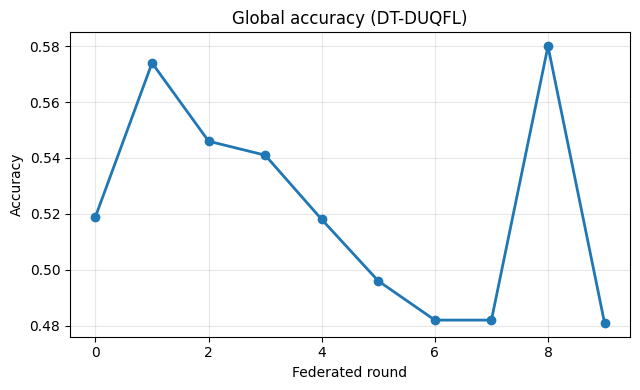

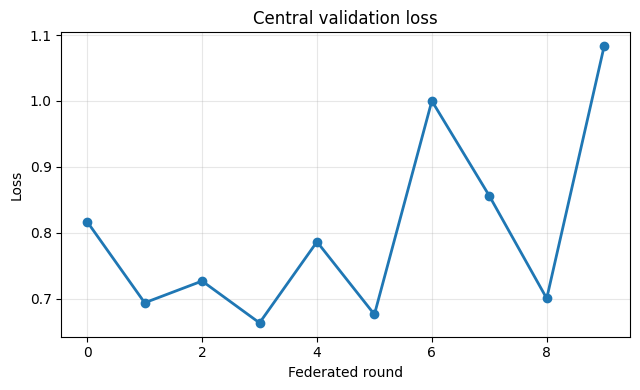

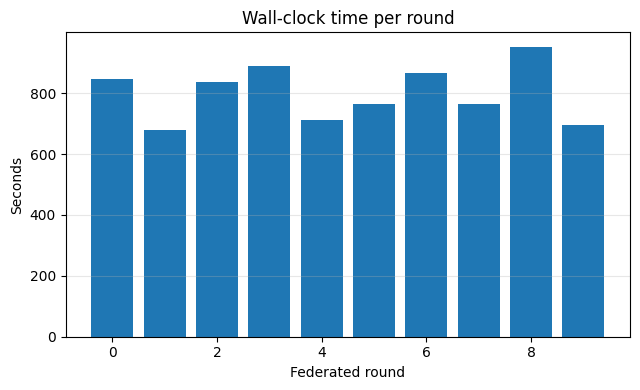

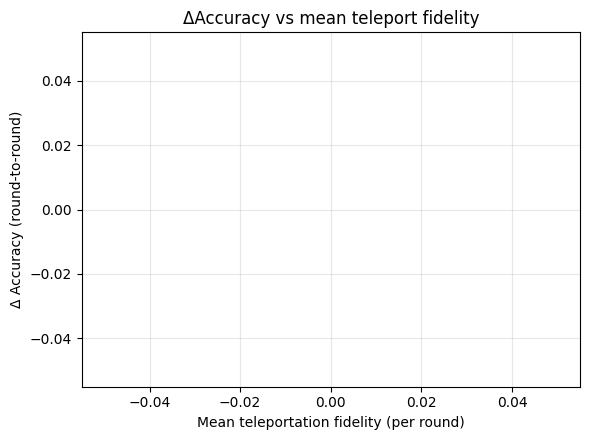

No β values to plot.


/tmp/ipython-input-1633266548.py:129: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(arr, vert=True, labels=["final"])


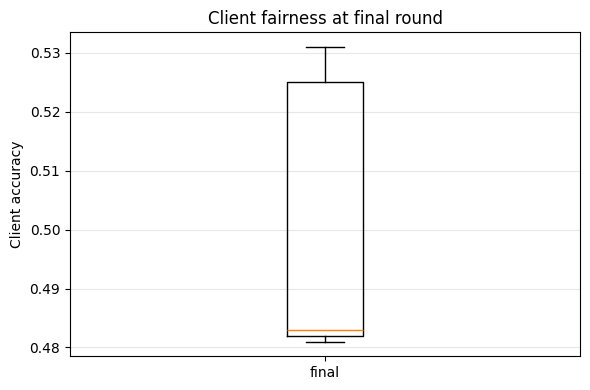

Total training time: 10362.95 s


In [27]:
# Initialize a global list to track global loss
global_loss_per_round = []

# Display information about the data assigned to each client, including epoch-wise splits
for idx, client in enumerate(clients):
    print(f"Client {idx + 1}:")
    for epoch in range(num_epochs):
        print(f"  Epoch {epoch + 1}: Train data samples: {len(client.data[epoch])}")
    print(f"  Test data samples: {len(client.test_data)}")

# Display information about the data assigned to each client
for idx, client in enumerate(clients):
    print(f"Client {idx + 1}:")
    print(f"  Train data epochs: {len(client.data)}")
    print(f"  Test data samples: {len(client.test_data)}")

    # Accessing the number of features in a sequence
    if client.data:
        num_features=client.data[0][0]['sequence'].shape[0]  # Access first data point of epoch 0
        #num_features = client.data[0]['sequence'].shape[0]
        print(f"  Number of features in a sequence: {num_features}")

def reset_state():
    # Reset the objective value, learning rate, and perturbation after each client
    global objective_func_vals, learning_rates, perturbations
    objective_func_vals = []  # Reset objective values
    learning_rates = []  # Reset learning rates
    perturbations = []  # Reset perturbations
# Function to reset callback graph state after each round
def reset_callback_graph():
    global gradient_moving_avg, learning_rates, perturbations

    # Reset the state variables to start fresh for the next round
    gradient_moving_avg = np.zeros_like(gradient_moving_avg)  # Reset gradient moving average
    learning_rates = [initial_learning_rate]  # Reset learning rates list to initial value
    perturbations = [initial_perturbation]  # Reset perturbations list to initial value
import csv

# Path to store the best client's data
#best_client_csv_file = '/content/drive/My Drive/Best_Client_DQFL_Genome_IID_22_04_2025_Teleport.csv'


# Update CSV headers to include round time
best_headers = ["Federated Round", "Client Number", "Round Duration (s)"]
with open(best_client_csv_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(best_headers)

# Function to update the best client data
def save_best_client_results(federated_round, best_client_index, round_duration):
    with open(best_client_csv_file, mode='a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow([federated_round,
                         best_client_index,
                         f"{round_duration:.4f}"])


# Clear the CSV file for a new run
clear_csv_file()

# Define validation data
X_val = np.array([data_point["sequence"] for data_point in np_test_data])
y_val = np.array([data_point["label"] for data_point in np_test_data])


# --- Before starting  federated loop: initialize the CSV with a header ---
with open(validation_csv_file, mode='w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(['Round', 'Central Validation Loss'])

validation_loss_per_round = []

# Wrap the epoch loop with tqdm
for epoch in tqdm(range(num_federated_layers), desc="Training Progress", leave =True):
    round_start = time.time()

    global_model_weights[epoch] = []
    epoch_train_accuracies, epoch_test_accuracies = [], []
    best_client_index = -1
    best_client_accuracy = -1
    best_client_model = None
    print("\n")
    print(f"Fed_Epoch: {epoch}")
    round_losses = []  # Track individual client losses for this round


    for index, client in enumerate(clients):
        print("\n")
        print(f"Fed_Epoch {epoch}, Client {index + 1}:")
        reset_state()

        try:
            # Ensure you're using the correct index for data
            current_data = client.data[epoch]  # This assumes data is structured in epochs
            print(f"Training data for epoch {epoch}: {len(current_data)}")
        except IndexError:
            print(f"No data available for epoch {epoch} for Client {index + 1}")
            continue  # Skip this client for the current epoch

        model, train_score, test_score, train_time = train_qnn_model(
            client.data[epoch],
            client.test_data,
            client_id=index,
            layer=epoch,
        )

        epoch_train_accuracies.append(train_score)
        epoch_test_accuracies.append(test_score)

        # Fetch the client's loss (assumes train_qnn_model returns it)
        #current_loss = objective_func_vals[-1]  # Fetch latest loss
        #round_losses.append(current_loss)
        # Calculate global loss for the current round as the average of client losses


        # Check if this client has the best accuracy so far
        if train_score > best_client_accuracy:
            best_client_accuracy = train_score
            best_client_index = index
            best_client_model = model  # Directly store the best client's model

    #global_loss = sum(round_losses) / len(round_losses)
    #global_loss_per_round.append(global_loss)  # Store the global loss

    #print(f"Global Loss for Round {epoch}: {global_loss}")

    round_duration = time.time() - round_start
    round_times.append(round_duration)
    print(f"Time for Round {epoch}: {round_duration:.2f} s")

    #Save best client *and* round duration to CSV
    save_best_client_results(epoch, best_client_index, round_duration)
  # Save to best client CSV
    print(f"Best client for epoch {epoch} is Client {best_client_index + 1} with test accuracy {best_client_accuracy:.2f}")

    #-----------------------------------------------------------------Teleportation------------------------------------------------

    ## --- Quantum Teleportation-based Model Update Transfer ---
    # Extract, teleport, and update the global model parameters.
    # Choose quantum update transmission scheme:
    #use_teleportation = True  # Set to False to simulate pure entanglement transfer



    # Treat the best client's model as the global model for the next round
    #Extract
    global_model = best_client_model
    global_params = global_model.weights
    #Teleport
    # Suppose 'global_params' is your chosen parameter vector for the round
    use_teleportation = False

    if use_teleportation:
      backend = make_backend(noise='med', shots=256)  # build once per round
      updated_params, info = teleport_parameters(
        global_params,
        mode='perturb',           # 'demo' for no change, 'perturb' to actually affect params
        noise='med',
        shots=256,
        backend=backend,
        show_histogram=True,     # True only for spot checks
        apply_shrinkage=True      # scale Δθ by fidelity (robust)
      )
    else:
      #updated_params = np.asarray(global_params, dtype=np.float32)
      #instead of the above we inject gaussian noise inot classical updates

    # Classical transport baseline WITH matched noise.
    # Option A (preferred): if have a target fidelity per round (e.g., from telemetry), use it:
    # F_target = 0.78  # ← example; replace with  per-round target if available
    # sigma = sigma_from_fidelity(F_target)

    # Option B: use the same 'noise preset' you’d have used for teleportation:
      noise = 'med'   # keep consistent with  experiment config
      sigma = sigma_from_preset(noise)

      # Inject circular (wrapped) Gaussian noise into angle parameters
      updated_params = inject_classical_angle_noise(
          np.asarray(global_params, dtype=np.float32),
          sigma=sigma
      )

      # For logging consistency (no teleportation ⇒ no fidelity/beta)
      # Provide a placeholder info dict for uniform logging
      info = {
        'theta_out': None,
        'delta_tel': None,
        'fidelity' : np.array([np.nan], dtype=float),  # not defined for classical
        'beta'     : np.nan,                           # not used
        'noise'    : noise_preset,
        'shots'    : None,
        'sigma'    : float(sigma)                      # useful to log!
      }
    # (optional) log:
    print(
      "beta=",
      info['beta'],
      "mean fidelity=",
      (float(info['fidelity'].mean()) if np.isfinite(info['fidelity']).any() else "NA"),
      "sigma=",
      (f"{info['sigma']:.4f}" if 'sigma' in info else "NA")
    )
    # push to clients
    global_model.initial_point = updated_params
    for client in clients:
        client.primary_model = global_model

    # (optional) log:
    print("beta=", info['beta'], "mean fidelity=", float(info['fidelity'].mean()))


    # Evaluate the global model on the new test data
    global_accuracy = get_accuracy(global_model, test_sequences, test_labels)
    global_model_accuracy.append(global_accuracy)

    clients_train_accuracies.append(epoch_train_accuracies)
    clients_test_accuracies.append(epoch_test_accuracies)

    print(f"Global Model Accuracy in Epoch {epoch}: {global_accuracy:.2f}")
    print("----------------------------------------------------------")


    # evaluate central validation
    L_val = compute_validation_loss(global_model, X_val, y_val)
    validation_loss_per_round.append(L_val)
    print(f"After round {epoch}, central val loss = {L_val:.4f}\n")

    # ========= METRICS LOGGER: per-round logging (AFTER values exist) =========
    _rounds.append(epoch)
    _global_acc.append(float(global_accuracy))
    _val_losses.append(float(L_val))
    _round_times_plot.append(float(round_duration))

    if use_teleportation and ('info' in locals()) and (info is not None):
        _fidelity_means.append(float(info['fidelity'].mean()))
        _betas.append(float(info['beta']))
    else:
        _fidelity_means.append(np.nan)
        _betas.append(np.nan)

    # Δ accuracy vs previous round
    if len(_global_acc) >= 2:
        _delta = _global_acc[-1] - _global_acc[-2]
    else:
        _delta = np.nan
    _delta_acc.append(_delta)

    # client accuracies this round
    metrics_log_round(
        metrics,
        round_idx=epoch,
        acc_global=global_accuracy,
        client_accs=epoch_test_accuracies,
        time_s=round_duration,
        val_loss=L_val,
        use_teleportation=use_teleportation,
        info=info if (use_teleportation and ('info' in locals())) else None,
        noise=noise_preset if use_teleportation else None,
        shots=shots_used if use_teleportation else None,
    )


    # --- Append the latest validation loss to the CSV ---
    with open(validation_csv_file, mode='a', newline='') as f:
        writer = csv.writer(f)
        writer.writerow([epoch, L_val])



    # Save results for the current iteration of the client in the federated round
    from google.colab import drive

    # Step 1: Mount Google Drive
    #drive.mount('/content/drive')

    # Step 2: Define the save path in Google Drive
    #save_path = '/content/drive/MyDrive/DQFL_Genome_IID_Global__22_04_2025_Teleport.csv'


    # Save accuracies to CSV after each epoch (or at the end of all epochs)
    save_accuracies_to_csv(global_model_accuracy, clients_train_accuracies, clients_test_accuracies, filename=global_csv_file)
    # After each round, reset callback state to prepare for the next round
    reset_callback_graph()
    print(f"File saved to {global_csv_file}")

# ========= METRICS LOGGER: finalize & plots =========
arr = metrics_finalize(metrics)
print(f"Metrics saved to {metrics['log_path']}. Rows logged: {len(metrics['rows'])}")
print(f"AUC (global accuracy vs rounds): {compute_auc(_global_acc):.3f}")

# Plots
plot_accuracy_curve(_rounds, _global_acc, label="Global accuracy (DT-DUQFL)")
plot_val_loss(_rounds, _val_losses, label="Central validation loss")
plot_time_per_round(_rounds, _round_times_plot)
plot_fidelity_vs_delta_acc(_fidelity_means, _delta_acc, label="ΔAccuracy vs mean teleport fidelity")
plot_beta_hist(_betas)

# Client fairness at the final round
if len(clients_test_accuracies) > 0:
    final_client_accs = clients_test_accuracies[-1]  # list per client
    plot_client_fairness_last_round(final_client_accs)

#print("Accuracy data saved to", csv_file_path)
# After loop, compute total elapsed time
total_training_time = time.time() - overall_start
print(f"Total training time: {total_training_time:.2f} s")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
#print("Accuracy data saved to", csv_file_path)
# After loop, compute total elapsed time
total_training_time = time.time() - overall_start
print(f"Total training time: {total_training_time:.2f} s")

In [ ]:
print(f"Saved validation loss per round to {validation_csv_file}")
# 10) Plot validation trajectory
plt.plot(validation_loss_per_round, marker='o')
plt.xlabel('Round')
plt.ylabel('Central Validation Loss')
plt.title('Federated QFL Validation Loss vs Round')
plt.grid(True)
plt.show()

In [ ]:
# Define the path to save global loss
global_loss_csv = '/content/drive/My Drive/Federated_Global_Loss_22_04_2025.csv'

# Write headers to the CSV file (only at the beginning)
if epoch == 0:
    with open(global_loss_csv, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["Federated Round", "Global Loss"])

# Append the global loss after each round
with open(global_loss_csv, mode='a', newline='') as file:
    writer = csv.writer(file)
    writer.writerow([epoch, global_loss])


In [ ]:
import matplotlib.pyplot as plt

# Plot global loss over federated rounds
plt.figure(figsize=(10, 6))
plt.plot(range(len(global_loss_per_round)), global_loss_per_round, marker='o', color='blue', label="Global Loss")
plt.xlabel("Federated Round")
plt.ylabel("Global Loss")
plt.title("Global Loss Over Federated Rounds")
plt.legend()
plt.grid(True)
plt.show()


Split data as iid and non-iid

In [ ]:


#Introduce custome cross entropy function
import numpy as np

# Callback for updating learning rate dynamically with deep unfolding principles
def deep_unfolding_learning_rate_adjustment(obj_func_eval, gradients=None, client_id=None, layer=None):
    global gradient_moving_avg, learning_rates, perturbations,meta_alpha, meta_epsilon, momentum

    # Initialize moving average for gradients
    if gradients is not None:
        if not isinstance(gradient_moving_avg, np.ndarray) or gradient_moving_avg.size == 0:
            gradient_moving_avg = gradients
        else:
            # Update moving average of gradients (Momentum)
            gradient_moving_avg = momentum * gradient_moving_avg + (1 - momentum) * gradients
        # Calculate the average gradient
        avg_gradient = np.mean(gradient_moving_avg)

        # Normalize delta_lr by L2 norm of the gradient
        norm_gradient = np.linalg.norm(gradients)

        '''
        # Normalization to prevent instability
        norm_gradient = gradients / (np.linalg.norm(gradients) + 1e-8)
        avg_gradient = np.mean(norm_gradient)
        '''
        # Trainable scaling for deep unfolding (meta-parameter)
        meta_alpha = 0.01  # This can be learned via a hypernetwork or meta-learning
        meta_epsilon = 1e-6  # Small offset to ensure numerical stability
        # Gradually adjust learning rate based on gradient signs and magnitude
        # This formula gradually adds or subtracts from the learning rate instead of multiplication
        delta_lr = meta_alpha * np.sign(avg_gradient) * np.sqrt(np.abs(avg_gradient) + meta_epsilon) / (norm_gradient + 1e-6)

        #delta_lr = meta_alpha * np.sign(avg_gradient) * np.sqrt(np.abs(avg_gradient) + meta_epsilon)
    # Apply gradual adjustment (either addition or subtraction based on the direction of the gradient)
        if avg_gradient > 0:
            delta_lr = delta_lr - 0.001  # Decrease if gradient is positive (potential overfitting)
        else:
            delta_lr = delta_lr + 0.001  # Increase if gradient is negative (potential underfitting)
    else:
        delta_lr = 0

    # Compute new learning rate with clamping for stability
    new_lr = max(0.001, min(5.0, learning_rates[-1] + delta_lr)) if learning_rates else initial_learning_rate

    # Update per-client, per-layer information if federated
    if client_id is not None and layer is not None:
        if client_id not in client_data:
            client_data[client_id] = {'federated_layers': {}}
        if layer not in client_data[client_id]['federated_layers']:
            client_data[client_id]['federated_layers'][layer] = {'objective_values': [], 'learning_rates': []}

        # Store loss and learning rate for the specific client and layer
        client_data[client_id]['federated_layers'][layer]['objective_values'].append(obj_func_eval)
        client_data[client_id]['federated_layers'][layer]['learning_rates'].append(new_lr)

    # Store global metrics
    objective_func_vals.append(obj_func_eval)  # Store the loss value globally
    learning_rates.append(new_lr)  # Append the new learning rate to the history

    # Update meta-parameters (meta_alpha and meta_epsilon) using gradient descent
    #meta_gradients = compute_meta_gradients(gradients, avg_gradient, delta_lr)
    #meta_alpha -= meta_learning_rate * meta_gradients['alpha']
    #meta_epsilon -= meta_learning_rate * meta_gradients['epsilon']

    # Debug output for analysis
    # print(f"Objective Function Value: {obj_func_eval:.6f}, New Learning Rate: {new_lr:.6f}")

    return new_lr


def callback_graph(weights, loss):
    """Callback to log and synchronize loss during training."""
    #print(f"Loss = {loss}")
    if len(objective_func_vals) == 0 or loss != objective_func_vals[-1]:
        objective_func_vals.append(loss)

spsa_optimizer = SPSA(maxiter=50, learning_rate=0.01, perturbation = 0.15, callback=lambda nfev, params, obj_func_eval, stepsize, accept: deep_unfolding_learning_rate_adjustment(obj_func_eval, stepsize))



# Define the CSV file path
csv_file_path = 'federated_learning_accuracy.csv'

# Open the CSV file in write mode and add headers (if starting fresh)
with open(csv_file_path, mode='w', newline='') as file:
    writer = csv.writer(file)
    # Write the header
    writer.writerow(['Epoch', 'Global Accuracy'] + [f'Client {i+1} Final Accuracy' for i in range(num_clients)])



new ways to average